<font size="5" color="red" face="arial">AB testing project: Conversion rate and Gross revenue evaluations</font>

## <font color="green">Helper functions</font>

In [1]:
def welch_ttest(x, y):
    
     ## Welch-Satterthwaite Degrees of Freedom ##
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        t, p = stats.ttest_ind(x, y, equal_var = False)
        print("\n",
              f"Welch's t-test= {t:.4f}", "\n",
              f"p-value = {p:.4f}", "\n",
              f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
        
        return p

## 1 - AB Testing: evaluating conversion rate

### 1.1 - Library imports

In [117]:
# Basic libraries

import pandas as pd
import numpy as np

# Libraries for frequentist inference

from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower
from scipy.stats import chi2_contingency

In [118]:
# Libraries for plots and Bayesian inference

from bayesian_testing.experiments import BinaryDataTest
import seaborn as sns
import matplotlib.pyplot as plt


# Remove warning messages related to datetime

import logging

logging.basicConfig(level='INFO')

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

### 1.2 - Data check

In [89]:
df = pd.read_csv('/home/gustavo/repos/AB_testing/ab_data.csv')

df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [90]:
# Checking NA's

df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [91]:
# Checking duplicated rows

df.duplicated().sum()

0

In [92]:
# Checking data types

df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [93]:
# Converting 'timestamp' column to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['timestamp'].head()

0   2017-01-21 22:11:48.556739
1   2017-01-12 08:01:45.159739
2   2017-01-11 16:55:06.154213
3   2017-01-08 18:28:03.143765
4   2017-01-21 01:52:26.210827
Name: timestamp, dtype: datetime64[ns]

In [94]:
# Creating 'non-converted' column

df['non-converted'] = df['converted'].apply(lambda x: 1 if x==0 else 0)

df.head()

,user_id,timestamp,group,landing_page,converted,non-converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [95]:
# Checking Countrol -> old_page and Treatment -> new_page count

pd.DataFrame(df[['group','landing_page']].value_counts()).rename(columns={0:'Count'})

,,Count
group,landing_page,
treatment,new_page,145311
control,old_page,145274
treatment,old_page,1965
control,new_page,1928


In [96]:
# There are Control group that received new_page as well as Treatment that received old_page
## these inconsistencies must be removed


df = df[(df['group']=='control') & (df['landing_page']=='old_page') | (df['group']=='treatment') & (df['landing_page']=='new_page')]

df

,user_id,timestamp,group,landing_page,converted,non-converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0
...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1


In [97]:
# Checking it again

pd.DataFrame(df[['group','landing_page']].value_counts()).rename(columns={0:'Count'})

,,Count
group,landing_page,
treatment,new_page,145311
control,old_page,145274


In [98]:
# Sort dataframe by timestamp

df = df.sort_values(by='timestamp', ignore_index=True)

df

,user_id,timestamp,group,landing_page,converted,non-converted
0,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,1
1,781507,2017-01-02 13:42:15.234051,control,old_page,0,1
2,737319,2017-01-02 13:42:21.786186,control,old_page,0,1
3,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,1
4,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,1
...,...,...,...,...,...,...
290580,799244,2017-01-24 13:41:15.325359,treatment,new_page,0,1
290581,808330,2017-01-24 13:41:19.152664,control,old_page,0,1
290582,843121,2017-01-24 13:41:44.097174,treatment,new_page,0,1
290583,836373,2017-01-24 13:41:52.604673,control,old_page,0,1


In [99]:
# Removing duplicated user_id keeping the first occurrence

df = df.drop_duplicates(subset=['user_id'], keep='first')

df

,user_id,timestamp,group,landing_page,converted,non-converted
0,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,1
1,781507,2017-01-02 13:42:15.234051,control,old_page,0,1
2,737319,2017-01-02 13:42:21.786186,control,old_page,0,1
3,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,1
4,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,1
...,...,...,...,...,...,...
290580,799244,2017-01-24 13:41:15.325359,treatment,new_page,0,1
290581,808330,2017-01-24 13:41:19.152664,control,old_page,0,1
290582,843121,2017-01-24 13:41:44.097174,treatment,new_page,0,1
290583,836373,2017-01-24 13:41:52.604673,control,old_page,0,1


In [100]:
# Unique 'user_id'

len(df['user_id'].unique())

290584

In [80]:
# Generating matrix for chi-squared test

df_matrix = df[['group','converted','non-converted']].groupby("group").sum()

df_matrix

,converted,non-converted
group,,
control,17489,127785
treatment,17264,128046


In [81]:
# Droping index name

df_matrix.index.name = None

df_matrix

,converted,non-converted
control,17489,127785
treatment,17264,128046


### 1.3 - Calculating sample size

In [82]:
# Conversion rate of current page is 12%. It is expected 14% of conversion rate for Treatment page

In [101]:
# conversion rates
actual_conversion_rate = 0.12
expected_conversion_rate = 0.14


# significance level
alpha = 0.05

# power
power = 0.8

# effect size (2 * (arcsin(sqrt(prop1)) - arcsin(sqrt(prop2))))
effect_size = proportion_effectsize(actual_conversion_rate, expected_conversion_rate)

# sample_number
nobs1 = int(
            np.ceil(
                NormalIndPower().solve_power(effect_size = effect_size,
                                             alpha = alpha,
                                             power = power)))

print(f'Minimum required sample number for each group: {nobs1} samples ')

Minimum required sample number for each group: 4433 samples 


In [102]:
# Available number of samples of each group

df[['group']].value_counts()

group    
treatment    145310
control      145274
dtype: int64

In [112]:
# Sampling groups

df_control_sampled = df[df['group']=='control'].sample(n=nobs1, random_state=42)

df_treatment_sampled = df[df['group']=='treatment'].sample(n=nobs1, random_state=42)


# Joining sampled groups

df_sampled = pd.concat([df_control_sampled, df_treatment_sampled]).sort_values(by='timestamp')

### 1.4 - Hypothesis test

In [113]:
# Generating contingency table for chi-squared test

df_matrix = pd.crosstab(df_sampled['group'], df_sampled['converted'], rownames=['Group:'])

df_matrix.columns = ['non-converted','converted']

df_matrix

,non-converted,converted
Group:,,
control,3910,523
treatment,3916,517


In [114]:
# Chi-square test

statistic, pvalue, dof, expected_freq = chi2_contingency(df_matrix)

print(f'p-value: {pvalue}')

p-value: 0.8689250419221012


### 1.5 - Bayesian test

In [120]:
# Reformating timestamp datetime (convert datetime to str to remove hour/min/second):

df['timestamp'] = df['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [121]:
df

,user_id,timestamp,group,landing_page,converted,non-converted
0,922696,2017-01-02,treatment,new_page,0,1
1,781507,2017-01-02,control,old_page,0,1
2,737319,2017-01-02,control,old_page,0,1
3,818377,2017-01-02,treatment,new_page,0,1
4,725857,2017-01-02,treatment,new_page,0,1
...,...,...,...,...,...,...
290580,799244,2017-01-24,treatment,new_page,0,1
290581,808330,2017-01-24,control,old_page,0,1
290582,843121,2017-01-24,treatment,new_page,0,1
290583,836373,2017-01-24,control,old_page,0,1


In [122]:

# Bayesian test


# ========= Creating lists to store metrics ==============

# Probability of being best
prob_control_best = []
prob_treatment_best = []

# Expected loss
expected_loss_control = []
expected_loss_treatment = []

# Zeros and ones list
zeros_ones_control = []
zeros_ones_treatment = []


# ========== Starting iteration for Bayesian tests ====================


for i in df['timestamp'].unique(): # Iterando em cada dia diferente
        
    # 1- Splitting groups for each day:
    
    # Control
    data_control_group = df.loc[(df['group']=='control') & (df['timestamp']==i), 'converted'].to_list()
    # Treatment
    data_treatment_group = df.loc[(df['group']=='treatment') & (df['timestamp']==i), 'converted'].to_list()
    
    
    # 2- Appending data to existing lists:
    
    # Control
    zeros_ones_control.append(data_control_group)
    # Treatment
    zeros_ones_treatment.append(data_treatment_group)
    
    
    # 3- Flatening lists:
    
    # Control
    data_control_group = sum(zeros_ones_control, [])
    # Treatment
    data_treatment_group = sum(zeros_ones_treatment, [])
    
    
    # 4- Initialize a test:
    
    test = BinaryDataTest()
    
    
    # 5- Add variant using raw data
    
    test.add_variant_data("Control", data_control_group)
    test.add_variant_data("Treatment", data_treatment_group)
    
    
    # 6- Evaluate test:
    
    results = test.evaluate(seed=42)
    
    
    # 7- Adding results to lists:
    
    # A) Probability of being best ->
    
    # Control
    prob_control_best.append(results[0]['prob_being_best'])
    # Treatment
    prob_treatment_best.append(results[1]['prob_being_best'])
    
    # B) # Expected loss ->
    
    # Control
    expected_loss_control.append(results[0]['expected_loss'])
    # Treatment
    expected_loss_treatment.append(results[1]['expected_loss'])

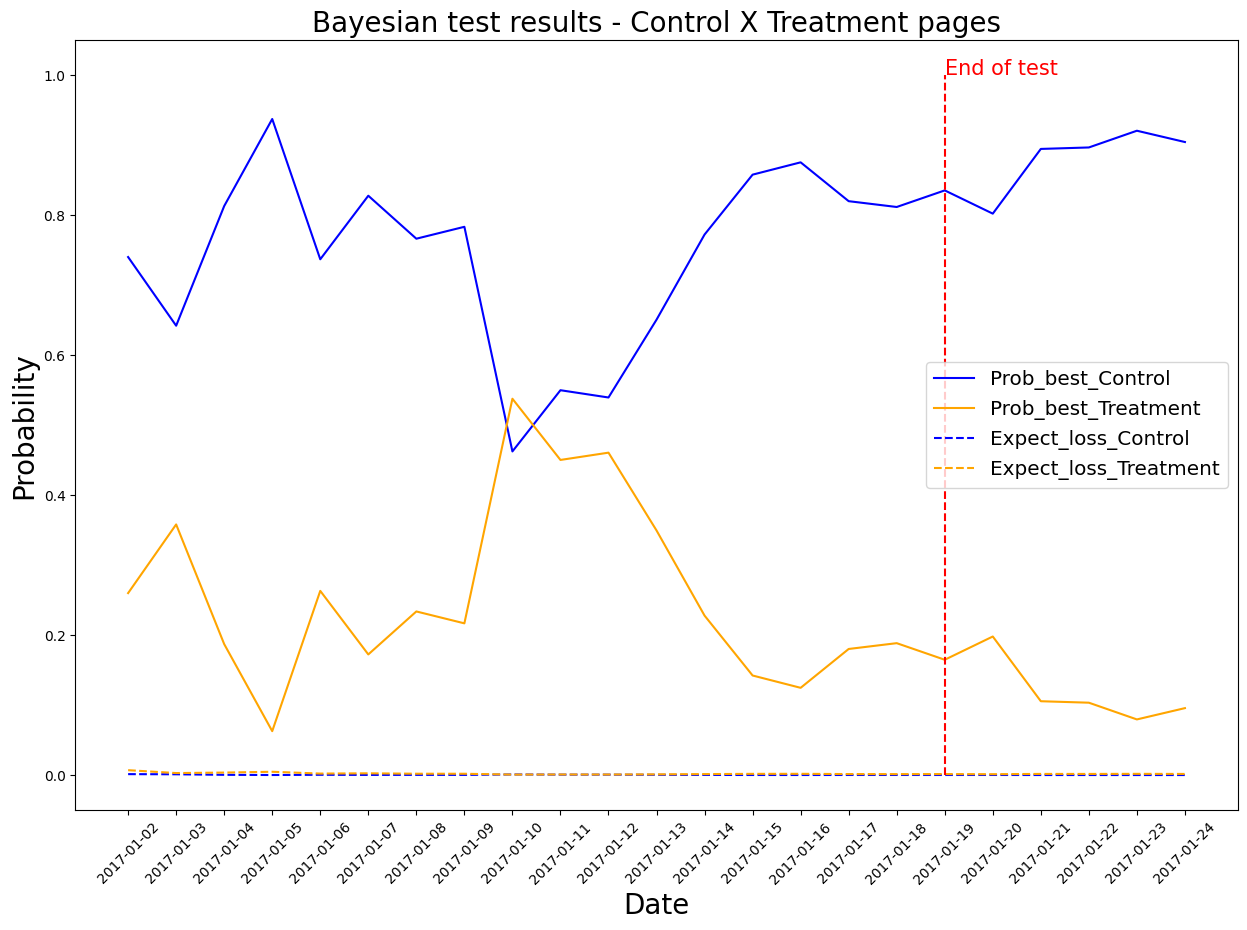

In [123]:
# Ploting results: 


plt.figure(figsize=(15,10)) # seting figure size


# Probability best
plt.plot(df['timestamp'].unique(), prob_control_best, label='Prob_best_Control', color='Blue')
plt.plot(df['timestamp'].unique(), prob_treatment_best, label='Prob_best_Treatment', color='Orange')

# Expected loss
plt.plot(df['timestamp'].unique(), expected_loss_control, label='Expect_loss_Control', color='Blue', linestyle='--')
plt.plot(df['timestamp'].unique(), expected_loss_treatment, label='Expect_loss_Treatment', color='Orange', linestyle='--')


plt.legend(loc='best', fontsize='x-large') # add legend box

plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
plt.ylabel('Probability', fontdict = {'color':'black','size':20}) # add xlabel legend


plt.title('Bayesian test results - Control X Treatment pages', fontdict = {'color':'black','size':20}) # add title to the plot

plt.vlines(x='2017-01-19', ymin=1e-20, ymax=1, linestyles ="dashed", colors ="red") # add vertical dashed line

plt.text(x='2017-01-19',y=1, s='End of test', fontdict={'color':'red','size':15}) # add text to follow vline

plt.xticks(rotation=45); # rotate xticks

### 1.6 - Frequentist X Bayesian approach

In [202]:
# Chi2 frequentist test


# ========= Creating lists to store metrics ==============


lista_datas = []

lista_pvalues = []


# ========== Starting iteration for Chi2 tests ====================

for i in df['timestamp'].unique():
    
    lista_datas.append(i)
    
    # Generating contingency table for chi-squared test
    df_contingency = pd.crosstab(df.loc[df['timestamp'].isin(lista_datas), 'group'],
                                 df.loc[df['timestamp'].isin(lista_datas), 'converted'],
                                 rownames=['Group:'])
    
    df_contingency.columns = ['non-converted','converted']
    
    # Chi2 test
    statistic, pvalue, dof, expected_freq = chi2_contingency(df_contingency)
    
    lista_pvalues.append(pvalue)

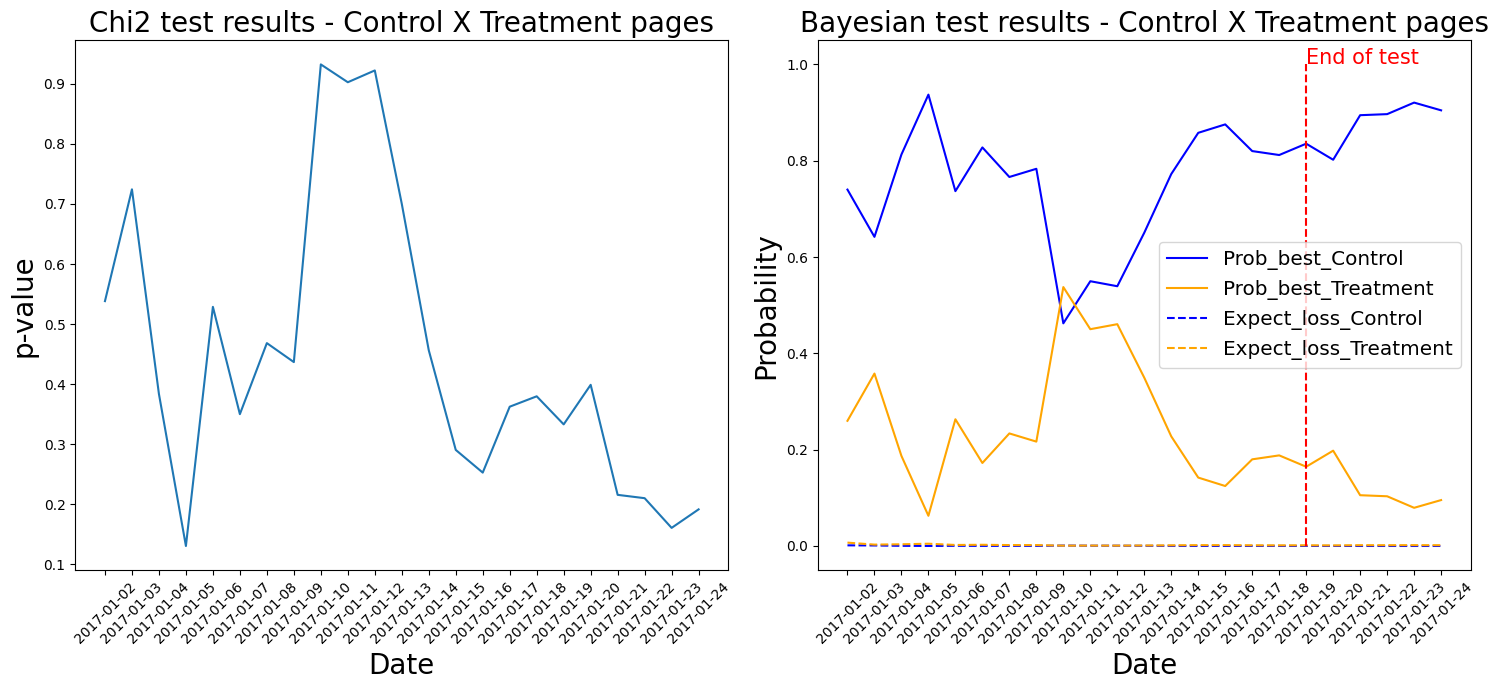

In [203]:

# Ploting results: 

plt.figure(figsize=(15,7)) # seting figure size


# Chi2 =================================

plt.subplot(1,2,1)

plt.plot(lista_datas, lista_pvalues)

plt.title('Chi2 test results - Control X Treatment pages', fontdict = {'color':'black','size':20}) # add title to the plot

plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
plt.ylabel('p-value', fontdict = {'color':'black','size':20}) # add xlabel legend

plt.xticks(rotation=45) # rotate xticks


# Bayesian ===============================

plt.subplot(1,2,2)

# Probability best
plt.plot(df['timestamp'].unique(), prob_control_best, label='Prob_best_Control', color='Blue')
plt.plot(df['timestamp'].unique(), prob_treatment_best, label='Prob_best_Treatment', color='Orange')

# Expected loss
plt.plot(df['timestamp'].unique(), expected_loss_control, label='Expect_loss_Control', color='Blue', linestyle='--')
plt.plot(df['timestamp'].unique(), expected_loss_treatment, label='Expect_loss_Treatment', color='Orange', linestyle='--')


plt.legend(loc='best', fontsize='x-large') # add legend box

plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
plt.ylabel('Probability', fontdict = {'color':'black','size':20}) # add xlabel legend


plt.title('Bayesian test results - Control X Treatment pages', fontdict = {'color':'black','size':20}) # add title to the plot

plt.vlines(x='2017-01-19', ymin=1e-20, ymax=1, linestyles ="dashed", colors ="red") # add vertical dashed line

plt.text(x='2017-01-19',y=1, s='End of test', fontdict={'color':'red','size':15}) # add text to follow vline

plt.xticks(rotation=45) # rotate xticks


plt.tight_layout();

## 2 - AB Testing: evaluating gross revenue

### 2.1 - Library imports

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import random

# Libraries for frequentist inference
from statsmodels.stats.power import tt_ind_solve_power
from scipy import stats

# Libraries for plots and Bayesian inference
from bayesian_testing.experiments import DeltaLognormalDataTest

import matplotlib.pyplot as plt
import seaborn as sns

### 2.2 - Data check

In [3]:
# Loading data

df = pd.read_csv('ab_testing.csv')

df

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A
...,...,...,...,...,...,...,...,...
45878,99994149,DEU,F,1897,3,2017-02-05,GRP B,I
45879,99995092,USA,F,899,1,2017-08-18,GRP B,A
45880,99996986,BRA,M,2194,6,2014-12-06,GRP B,A
45881,99997035,USA,M,2196,4,2017-04-05,GRP A,I


In [4]:
# Checking number of unique id's

len(df['uid'].unique())

45883

In [5]:
# Checking NA's

df.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [6]:
# Checking data types

df.dtypes

uid           int64
country      object
gender       object
spent         int64
purchases     int64
date         object
group        object
device       object
dtype: object

In [7]:
# Checking duplicated

df.duplicated().sum()

0

In [8]:
# Setting 'date' column as datetime

df['date'] = pd.to_datetime(df['date'])

In [9]:
# Checking if the same user id does not belong to more than 1 group

df[['uid','group']].groupby('uid').count().sort_values(by='group', ascending=False)

,group
uid,
11115722,1
70051633,1
70013059,1
70014245,1
70016073,1
...,...
40783010,1
40783265,1
40783344,1


In [10]:
# Checking gender ================================================


print('Gender')

print(df['gender'].value_counts())

print(df['gender'].value_counts(normalize=True))

Gender
M    23116
F    22767
Name: gender, dtype: int64
M    0.503803
F    0.496197
Name: gender, dtype: float64


In [11]:
# Checking Gender proportion - Group A

print('Group A gender proportion:')
print(df.loc[df['group']=='GRP A','gender'].value_counts(normalize=True))

# Checking Gender proportion - Group B

print('\nGroup B gender proportion:')
print(df.loc[df['group']=='GRP B','gender'].value_counts(normalize=True))

Group A gender proportion:
M    0.505802
F    0.494198
Name: gender, dtype: float64

Group B gender proportion:
M    0.501792
F    0.498208
Name: gender, dtype: float64


In [12]:
# Checking country ================================================

print('Country')

print(df['country'].value_counts())

print(df['country'].value_counts(normalize=True))

Country
USA    13998
BRA     9009
MEX     5528
DEU     3696
TUR     3537
FRA     2842
GBR     2809
ESP     1934
CAN     1513
AUS     1017
Name: country, dtype: int64
USA    0.305080
BRA    0.196347
MEX    0.120480
DEU    0.080553
TUR    0.077087
FRA    0.061940
GBR    0.061221
ESP    0.042151
CAN    0.032975
AUS    0.022165
Name: country, dtype: float64


In [13]:
# Checking Country proportion - Group A

print('Group A country proportion:')
print(df.loc[df['group']=='GRP A','country'].value_counts(normalize=True))


# Checking Country proportion - Group B

print('\nGroup B country proportion:')
print(df.loc[df['group']=='GRP B','country'].value_counts(normalize=True))

Group A country proportion:
USA    0.301056
BRA    0.196358
MEX    0.125429
DEU    0.082142
TUR    0.078013
FRA    0.062280
GBR    0.060237
ESP    0.042157
CAN    0.030336
AUS    0.021991
Name: country, dtype: float64

Group B country proportion:
USA    0.309128
BRA    0.196336
MEX    0.115502
DEU    0.078954
TUR    0.076156
GBR    0.062210
FRA    0.061598
ESP    0.042144
CAN    0.035630
AUS    0.022340
Name: country, dtype: float64


### 2.3 - Calculating sample size

In [14]:
# significance level
alpha = 0.05

# power
power = 0.8

lift = 1.063

country_list = list(df['country'].unique())

df_aux = pd.DataFrame({'Country':np.nan,
                       'Minimum sample number':np.nan,
                       'GRP A required':np.nan,
                       'GRP B required':np.nan,
                       'GRP A available':np.nan,
                       'GRP B available':np.nan,
                       'Actual spent': np.nan,
                       'Expected lift': np.nan,
                       'Test possible?': np.nan}, index=[i for i in range(len(df['country'].unique()))])

#df_aux['Country'] = country_list


for i, it in zip(country_list, df_aux.index):
    
    actual_mean_spent = df.loc[(df['country']==i) & (df['group']=='GRP A'), 'spent'].mean()
    
    expected_mean_spent = actual_mean_spent*lift
    
    
    # effect size
    effect_size = (expected_mean_spent - actual_mean_spent) / df.loc[df['group']=='GRP A', 'spent'].std()
    
    # sample_number
    nobs1 = tt_ind_solve_power(effect_size = effect_size, alpha = alpha, power = power)
    
    # preenchendo o df
    df_aux.loc[it, 'Country'] = i
    
    df_aux.loc[it, 'Minimum sample number'] = nobs1
    
    df_aux.loc[it, 'GRP A required'] = nobs1
    
    df_aux.loc[it, 'GRP B required'] = nobs1
    
    df_aux.loc[it, 'GRP A available'] = ((df['group']=='GRP A') & (df['country']==i)).sum()
    
    df_aux.loc[it, 'GRP B available'] = ((df['group']=='GRP A') & (df['country']==i)).sum()
    
    df_aux.loc[it, 'Actual spent'] = actual_mean_spent
    
    df_aux.loc[it, 'Expected lift'] = expected_mean_spent
    
    df_aux.loc[it, 'Test possible?'] = ['No' if df_aux.loc[it,'GRP B available'] < df_aux.loc[it,'GRP A required'] else 'Yes'][0]
    
    
df_aux[['Minimum sample number',
        'GRP A required',
        'GRP B required',
        'GRP A available',
        'GRP B available']] = np.ceil(df_aux[['Minimum sample number',
                                              'GRP A required',
                                              'GRP B required',
                                              'GRP A available',
                                              'GRP B available']]).astype('int')

df_aux

/home/gustavo/.pyenv/versions/3.8.0/envs/AB_testing/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/gustavo/.pyenv/versions/3.8.0/envs/AB_testing/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


,Country,Minimum sample number,GRP A required,GRP B required,GRP A available,GRP B available,Actual spent,Expected lift,Test possible?
0,MEX,2047,2047,2047,2886,2886,1902.705821,2022.576288,Yes
1,USA,2078,2078,2078,6927,6927,1888.376065,2007.343757,Yes
2,ESP,2302,2302,2302,970,970,1794.191753,1907.225833,No
3,GBR,2236,2236,2236,1386,1386,1820.470418,1935.160055,No
4,TUR,2070,2070,2070,1795,1795,1892.353203,2011.571455,No
5,DEU,2212,2212,2212,1890,1890,1830.453439,1945.772006,No
6,BRA,2053,2053,2053,4518,4518,1899.792165,2019.479071,Yes
7,FRA,2054,2054,2054,1433,1433,1899.752268,2019.436661,No
8,AUS,1930,1930,1930,506,506,1959.517787,2082.967407,No
9,CAN,2205,2205,2205,698,698,1833.154728,1948.643476,No


In [15]:
# Creating a list containing the countries that have the minimum number of samples for the test

countries_ab_list = df_aux.loc[df_aux['Test possible?']=='Yes','Country'].to_list()

countries_ab_list

['MEX', 'USA', 'BRA']

### 2.4 - Checking data distribution

In [16]:
# Filtering the dataframe to only countries where AB testing is possible 

df_ab = df[df['country'].isin(countries_ab_list)]

df_ab

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
5,11131070,USA,M,1796,4,2016-08-08,GRP B,I
...,...,...,...,...,...,...,...,...
45874,99986982,USA,F,3394,6,2017-05-03,GRP B,I
45877,99991883,BRA,M,2995,5,2017-06-22,GRP B,A
45879,99995092,USA,F,899,1,2017-08-18,GRP B,A
45880,99996986,BRA,M,2194,6,2014-12-06,GRP B,A


In [17]:
df_GRP_A_sampled = pd.DataFrame(columns=df_ab.columns)

df_GRP_B_sampled = pd.DataFrame(columns=df_ab.columns)

# Separating group A and group B

df_GRP_A = df_ab[df_ab['group']=='GRP A']

df_GRP_B = df_ab[df_ab['group']=='GRP B']

In [18]:
# Sampling data by country based on sample size calculation

for i in countries_ab_list:
    
    n_sampled_GRP_A = df_aux.loc[df_aux['Country']==i,'GRP A required'].values[0]
    
    df_sampled_A = df_ab[(df_ab['group']=='GRP A') & (df_ab['country']==i)].sample(n=n_sampled_GRP_A, random_state=42)
    
    df_GRP_A_sampled = pd.concat([df_GRP_A_sampled, df_sampled_A])
    
    
    n_sampled_GRP_B = df_aux.loc[df_aux['Country']==i,'GRP B required'].values[0]
    
    df_sampled_B = df_ab[(df_ab['group']=='GRP B') & (df_ab['country']==i)].sample(n=n_sampled_GRP_B, random_state=42)
    
    df_GRP_B_sampled = pd.concat([df_GRP_B_sampled, df_sampled_B])

In [19]:
# Joining back the sampled df group A and B

df_AB = pd.concat([df_GRP_A_sampled, df_GRP_B_sampled])

In [20]:
df_AB

,uid,country,gender,spent,purchases,date,group,device
7679,25981952,MEX,F,1497,3,2016-12-13,GRP A,I
39246,86959496,MEX,F,2494,6,2018-01-05,GRP A,I
38251,84978006,MEX,M,497,3,2016-07-27,GRP A,I
26569,62254922,MEX,M,299,1,2016-04-15,GRP A,A
18054,46080590,MEX,F,2096,4,2016-11-25,GRP A,I
...,...,...,...,...,...,...,...,...
38392,85241496,BRA,F,599,1,2016-10-01,GRP B,A
25471,60143852,BRA,F,1797,3,2016-07-15,GRP B,A
43643,95647935,BRA,F,1596,4,2016-04-20,GRP B,A
16113,42331972,BRA,F,3293,7,2018-01-07,GRP B,A


In [21]:
# Changing columns data type format

df_AB['uid'] = df_AB['uid'].astype('int')
df_AB['spent'] = df_AB['spent'].astype('float')

In [22]:
# Defining a dataframe that will contain data normality and variance test information

df_summary = pd.DataFrame(columns=['country','Shapiro p-value', 'Normal distribution?','Variance ratio','Equal Variances?'])

df_summary['country'] = df_AB['country'].unique()

df_summary

,country,Shapiro p-value,Normal distribution?,Variance ratio,Equal Variances?
0,MEX,NaN,NaN,NaN,NaN
1,USA,NaN,NaN,NaN,NaN
2,BRA,NaN,NaN,NaN,NaN


In [23]:
# Do the Shapiro test and evaluation of variances by country

for i in countries_ab_list:
    
    df_summary.loc[df_summary['country']==i, 'Shapiro p-value'] = stats.shapiro(df_AB.loc[df_AB['country']==i,'spent']).pvalue
    
    
    variance_list = [np.var(df_AB.loc[(df_AB['group']=='GRP A') & (df_AB['country']==i),'spent']), np.var(df_AB.loc[(df_AB['group']=='GRP B') & (df_AB['country']==i),'spent'])]
    
    df_summary.loc[df_summary['country']==i, 'Variance ratio'] = np.max(variance_list) / np.min(variance_list)

    
    
df_summary['Normal distribution?'] = ['No' if i<0.05 else 'Yes' for i in df_summary['Shapiro p-value']]

df_summary['Equal Variances?'] = ['No' if i>4 else 'Yes' for i in df_summary['Variance ratio']]

In [24]:
df_summary

,country,Shapiro p-value,Normal distribution?,Variance ratio,Equal Variances?
0,MEX,0.0,No,1.049738,Yes
1,USA,0.0,No,1.081985,Yes
2,BRA,0.0,No,1.061109,Yes


### 2.5 - Hypothesis test

In [25]:
df_AB

,uid,country,gender,spent,purchases,date,group,device
7679,25981952,MEX,F,1497.0,3,2016-12-13,GRP A,I
39246,86959496,MEX,F,2494.0,6,2018-01-05,GRP A,I
38251,84978006,MEX,M,497.0,3,2016-07-27,GRP A,I
26569,62254922,MEX,M,299.0,1,2016-04-15,GRP A,A
18054,46080590,MEX,F,2096.0,4,2016-11-25,GRP A,I
...,...,...,...,...,...,...,...,...
38392,85241496,BRA,F,599.0,1,2016-10-01,GRP B,A
25471,60143852,BRA,F,1797.0,3,2016-07-15,GRP B,A
43643,95647935,BRA,F,1596.0,4,2016-04-20,GRP B,A
16113,42331972,BRA,F,3293.0,7,2018-01-07,GRP B,A


In [26]:
alpha = 0.05

df_results = pd.DataFrame(columns=['País','Teste aplicado','Valor de p','Diferenças?'],
                          index=[i for i in range(len(df_AB['country'].unique()))])

df_results['País'] = df_AB['country'].unique()


for i in df_summary['country']:
    
    print(f'País avaliado:{i}')
    
    # Condition for non-parametric test of equal variances
    if (df_summary.loc[df_summary['country']==i, 'Shapiro p-value'].values[0] < alpha) & (df_summary.loc[df_summary['country']==i, 'Variance ratio'].values[0] < 4):
                
        # Apply Mann-Whitney test
        print('Teste estatístico selecionado baseado nos dados: Mann-Whitney')
        teste_escolhido='Mann-Whitney'
        results = stats.mannwhitneyu(x= df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP A'),'spent'].values,
                                     y= df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP B'),'spent'].values,
                                     use_continuity=True,
                                     alternative='two-sided',
                                     axis=0,
                                     method='auto',
                                     nan_policy='propagate',
                                     keepdims=False)
        
        # Test the p value to print the result
        print(f'Valor de p:{np.round(results.pvalue, 2)}')
        if results.pvalue < alpha:
            print('Existem diferenças entre os dois tratamentos\n')
            resultado = 'Significativo'
        
        else:
            print('NÃO Existem diferenças entre os dois tratamentos\n')
            resultado = 'Não significativo'
        
    
    # Condition for non-parametric test of different variances
    elif (df_summary.loc[df_summary['country']==i, 'Shapiro p-value'].values[0] < alpha) & (df_summary.loc[df_summary['country']==i, 'Variance ratio'].values[0] < 4):
        
        # Apply Welch's test
        print('Teste estatístico selecionado baseado nos dados: Welch')
        teste_escolhido='Welch'
        def welch_ttest(x, y):
             ## Welch-Satterthwaite Degrees of Freedom ##
                dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
                t, p = stats.ttest_ind(x, y, equal_var = False)
                print("\n",
                      f"Welch's t-test= {t:.4f}", "\n",
                      f"p-value = {p:.4f}", "\n",
                      f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
                
                return t,p
                
        results = welch_ttest(x=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP A'),'spent'].values,
                              y=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP B'),'spent'].values)
        
        # Test the p value to print the result
        print(f'Valor de p:{np.round(results.pvalue, 2)}')
        if results.pvalue < alpha:
            print('Existem diferenças entre os dois tratamentos\n')
            resultado = 'Significativo'
        
        else:
            print('NÃO Existem diferenças entre os dois tratamentos\n')
            resultado = 'Não significativo'
       
              
    # Condition for parametric test of equal variances
    elif (df_summary.loc[df_summary['country']==i, 'Shapiro p-value'].values[0] > alpha) & (df_summary.loc[df_summary['country']==i, 'Variance ratio'].values[0] < 4):    
        
        # Apply the parametric t test of equal variances
        print('Teste estatístico selecionado baseado nos dados: Parametric ttest - equal variances')
        teste_escolhido='T test - equal variances'
        results = stats.ttest_ind(x=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP A'),'spent'].values,
                                  y=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP B'),'spent'].values,
                                  equal_var = True)
        
        # Test the p value to print the result
        print(f'Valor de p:{np.round(results.pvalue, 2)}')
        if results.pvalue < alpha:
            print('Existem diferenças entre os dois tratamentos\n')
            resultado = 'Significativo'
        
        else:
            print('NÃO Existem diferenças entre os dois tratamentos\n')
            resultado = 'Não significativo'
        
    else:
        
        # Apply the parametric t test of unequal variances
        print('Teste estatístico selecionado baseado nos dados: Parametric ttest - unequal variances')
        teste_escolhido='T test - unequal variances'
        results = stats.ttest_ind(x=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP A'),'spent'].values,
                                  y=df_AB.loc[(df_AB['country']==i) & (df_AB['group']=='GRP B'),'spent'].values,
                                  equal_var = False)
        
        # Test the p value to print the result
        print(f'Valor de p:{np.round(results.pvalue, 2)}')
        if results.pvalue < alpha:
            print('Existem diferenças entre os dois tratamentos\n')
            resultado = 'Significativo'
        
        else:
            print('NÃO Existem diferenças entre os dois tratamentos\n')
            resultado = 'Não significativo'
    
    
    # Filling df_results - > results of statistical tests by country
    df_results.loc[df_results['País']==i, 'Teste aplicado'] = teste_escolhido
    
    df_results.loc[df_results['País']==i, 'Valor de p'] = np.round(results.pvalue, 2)
    
    df_results.loc[df_results['País']==i, 'Diferenças?'] = resultado

País avaliado:MEX
Teste estatístico selecionado baseado nos dados: Mann-Whitney
Valor de p:0.28
NÃO Existem diferenças entre os dois tratamentos

País avaliado:USA
Teste estatístico selecionado baseado nos dados: Mann-Whitney
Valor de p:0.35
NÃO Existem diferenças entre os dois tratamentos

País avaliado:BRA
Teste estatístico selecionado baseado nos dados: Mann-Whitney
Valor de p:0.53
NÃO Existem diferenças entre os dois tratamentos



In [27]:
df_results

,País,Teste aplicado,Valor de p,Diferenças?
0,MEX,Mann-Whitney,0.28,Não significativo
1,USA,Mann-Whitney,0.35,Não significativo
2,BRA,Mann-Whitney,0.53,Não significativo


### 2.6 - Bayesian test

In [28]:
# AGGREGATIONS FOR THE BAYESIAN TEST of DeltaLognormalDataTest()

In [105]:
# Criando o dataframe agrupado por ano, país e grupo
## apendando os elementos ao longo do tempo

# as operações necessárias para o alimentar os parâmetros de teste bayesiano serão efetuados nesse dataframe

df_grouped = df[['country','spent','date','group']].groupby([pd.Grouper(key='date', freq='Y'),'country','group']).agg(list).groupby(level=[1,2]).apply(lambda x: x.cumsum())

df_grouped

spent
date       country group                                                   
2014-12-31 AUS     GRP A  [499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...
                   GRP B   [997, 199, 1497, 698, 798, 2296, 1795, 597, 997]
           BRA     GRP A  [3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...
                   GRP B  [2995, 1195, 2593, 2094, 1595, 4890, 3093, 249...
           CAN     GRP A      [2195, 199, 1795, 1397, 499, 599, 2994, 1996]
...                                                                     ...
2018-12-31 MEX     GRP B  [1398, 2494, 997, 5684, 3194, 2395, 2495, 3095...
           TUR     GRP A  [3490, 7480, 2394, 3890, 599, 1098, 599, 1996,...
                   GRP B  [198, 299, 3190, 6086, 499, 2194, 2096, 1795, ...
           USA     GRP A  [697, 2492, 898, 299, 1696, 2595, 798, 1597, 8...
                   GRP B  [1994, 897, 3194, 1895, 2695, 899, 1896, 199, ...

[100 rows x 1 columns]

In [30]:
df_grouped = df_grouped.reset_index()

In [31]:
# 'totals' parameter
df_grouped['totals'] = df_grouped['spent'].apply(len)

# 'positives' parameter
df_grouped['positives'] = df_grouped['spent'].apply(lambda x: sum(i > 0 for i in x))

# 'sum_values' parameter
df_grouped['sum_values'] = df_grouped['spent'].apply(lambda x: sum(x))

# 'sum_logs' parameter
df_grouped['sum_logs'] = df_grouped['spent'].apply(lambda x: sum([np.log(i) for i in x if i > 0]))

# 'sum_logs_2' parameter
df_grouped['sum_logs_2'] = df_grouped['spent'].apply(lambda x: sum([np.square(np.log(i)) for i in x if i > 0]))

In [32]:
df_grouped


,date,country,group,spent,totals,positives,sum_values,sum_logs,sum_logs_2
0,2014-12-31,AUS,GRP A,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...",10,10,19056,73.222467,541.251965
1,2014-12-31,AUS,GRP B,"[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]",9,9,9874,61.267954,421.242908
2,2014-12-31,BRA,GRP A,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...",63,63,107541,450.868995,3272.477111
3,2014-12-31,BRA,GRP B,"[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249...",52,52,111842,388.001572,2921.707071
4,2014-12-31,CAN,GRP A,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]",8,8,11674,55.933219,397.113963
...,...,...,...,...,...,...,...,...,...
95,2018-12-31,MEX,GRP B,"[1398, 2494, 997, 5684, 3194, 2395, 2495, 3095...",2642,2642,4974127,19165.039968,140820.516246
96,2018-12-31,TUR,GRP A,"[3490, 7480, 2394, 3890, 599, 1098, 599, 1996,...",1795,1795,3396774,13036.080103,95864.807361
97,2018-12-31,TUR,GRP B,"[198, 299, 3190, 6086, 499, 2194, 2096, 1795, ...",1742,1742,3248846,12606.782136,92429.570270
98,2018-12-31,USA,GRP A,"[697, 2492, 898, 299, 1696, 2595, 798, 1597, 8...",6927,6927,13080781,50265.841061,369487.995964


In [33]:
# Bayesian test by Date and by Country

for i in df_grouped['date']: # iterate over dates
    
    for it in df_grouped['country']: # iterate over countries
        
                
        # initialize a test:
        test = DeltaLognormalDataTest()
        
        # add variant using aggregated data:
        test.add_variant_data_agg(name="A",
                                  totals=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'totals'].values[0],
                                  positives=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'positives'].values[0],
                                  sum_values=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'sum_values'].values[0],
                                  sum_logs=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'sum_logs'].values[0],
                                  sum_logs_2=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'sum_logs_2'].values[0]
                                 )
        
        test.add_variant_data_agg(name="B",
                                  totals=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'totals'].values[0],
                                  positives=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'positives'].values[0],
                                  sum_values=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'sum_values'].values[0],
                                  sum_logs=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'sum_logs'].values[0],
                                  sum_logs_2=df_grouped.loc[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'sum_logs_2'].values[0]
                                 )
        
        # evaluate test
        results = test.evaluate(seed=42)
        
        
        # Results (filling Dataframe)
        
        # GRP A -> prob A better than B
        df_grouped.at[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'prob_being_best'] = results[0]['prob_being_best']
        
        # GRP A -> expected loss
        df_grouped.at[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP A'), 'expected_loss'] = results[0]['expected_loss']
        
        
        # GRP B -> prob A better than A
        df_grouped.at[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'prob_being_best'] = results[1]['prob_being_best']
        
        # GRP B -> expected loss
        df_grouped.at[(df_grouped['date']==i) & (df_grouped['country']==it) & (df_grouped['group']=='GRP B'), 'expected_loss'] = results[1]['expected_loss']
        

In [34]:
df_grouped

,date,country,group,spent,totals,positives,sum_values,sum_logs,sum_logs_2,prob_being_best,expected_loss
0,2014-12-31,AUS,GRP A,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...",10,10,19056,73.222467,541.251965,0.89175,8.894321e+01
1,2014-12-31,AUS,GRP B,"[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]",9,9,9874,61.267954,421.242908,0.10825,9.701613e+02
2,2014-12-31,BRA,GRP A,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...",63,63,107541,450.868995,3272.477111,0.13005,4.273209e+02
3,2014-12-31,BRA,GRP B,"[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249...",52,52,111842,388.001572,2921.707071,0.86995,2.589039e+01
4,2014-12-31,CAN,GRP A,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]",8,8,11674,55.933219,397.113963,0.59275,8.126969e+15
...,...,...,...,...,...,...,...,...,...,...,...
95,2018-12-31,MEX,GRP B,"[1398, 2494, 997, 5684, 3194, 2395, 2495, 3095...",2642,2642,4974127,19165.039968,140820.516246,0.26920,4.085960e+01
96,2018-12-31,TUR,GRP A,"[3490, 7480, 2394, 3890, 599, 1098, 599, 1996,...",1795,1795,3396774,13036.080103,95864.807361,0.66715,1.365247e+01
97,2018-12-31,TUR,GRP B,"[198, 299, 3190, 6086, 499, 2194, 2096, 1795, ...",1742,1742,3248846,12606.782136,92429.570270,0.33285,4.154916e+01
98,2018-12-31,USA,GRP A,"[697, 2492, 898, 299, 1696, 2595, 798, 1597, 8...",6927,6927,13080781,50265.841061,369487.995964,0.80490,3.453165e+00


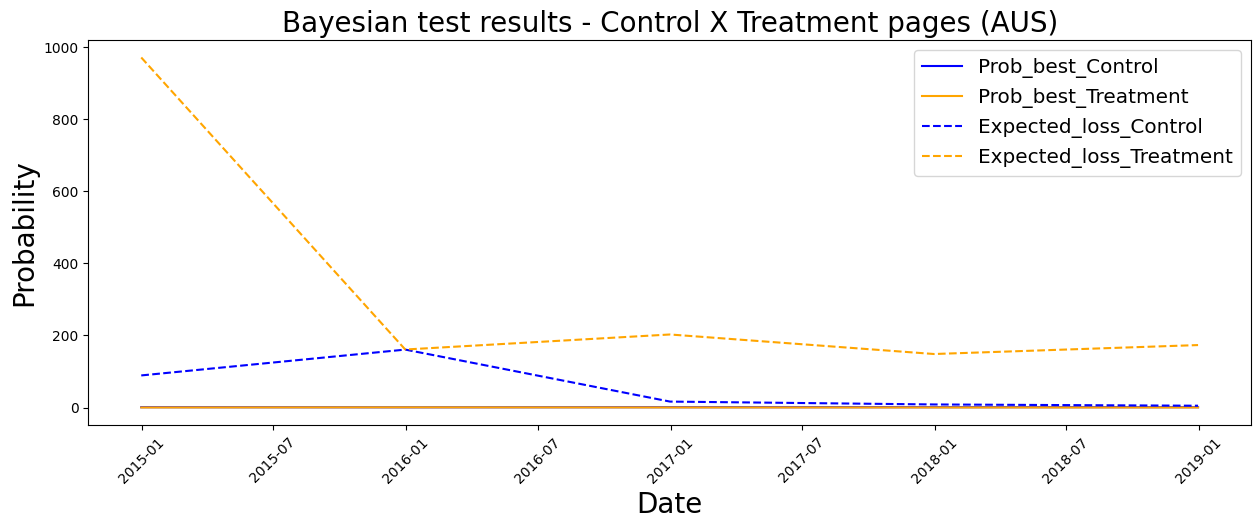

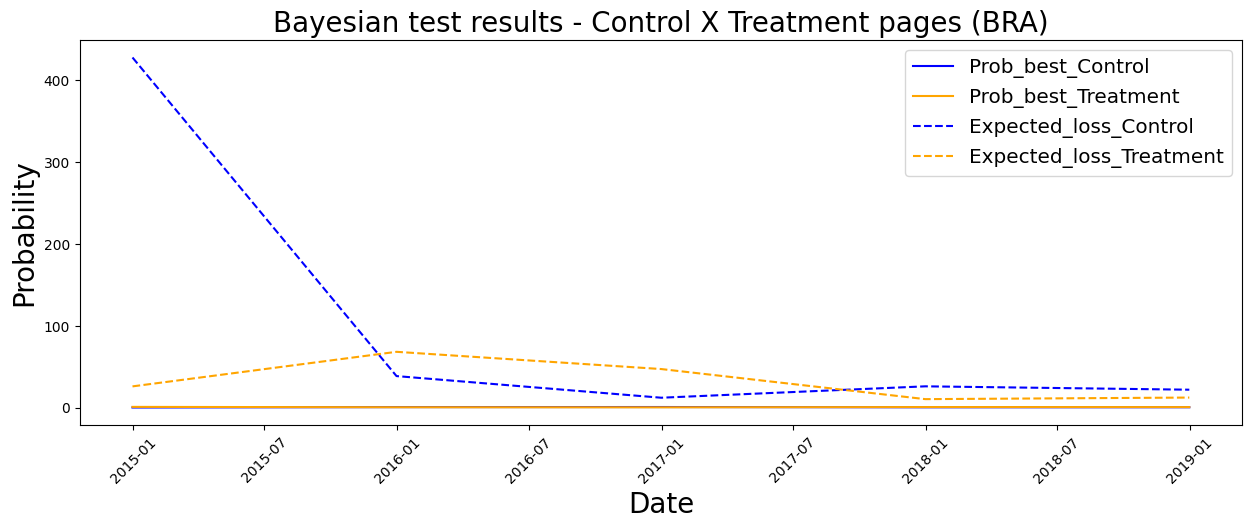

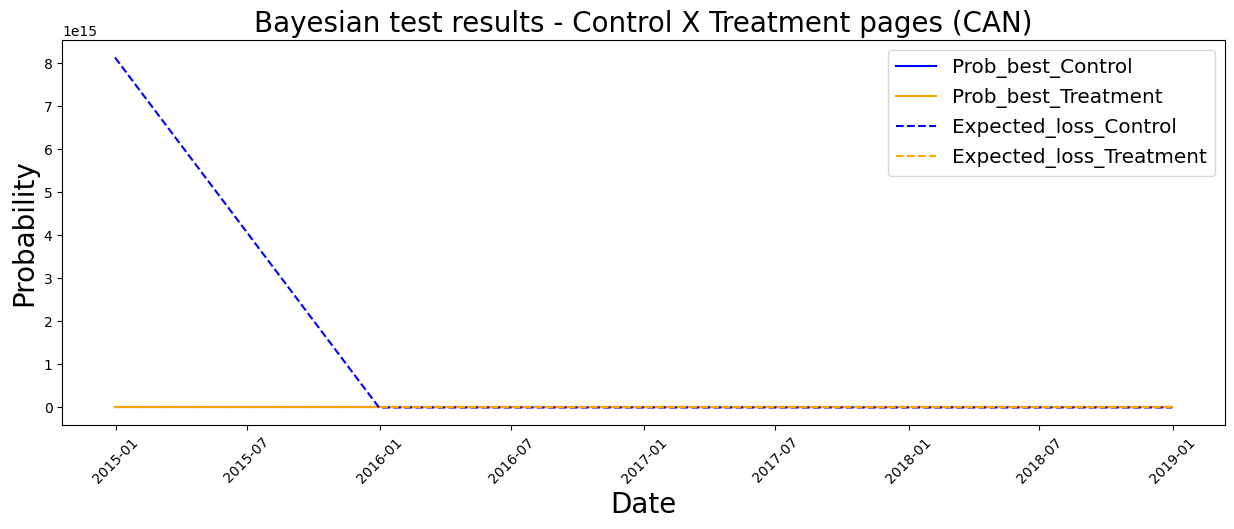

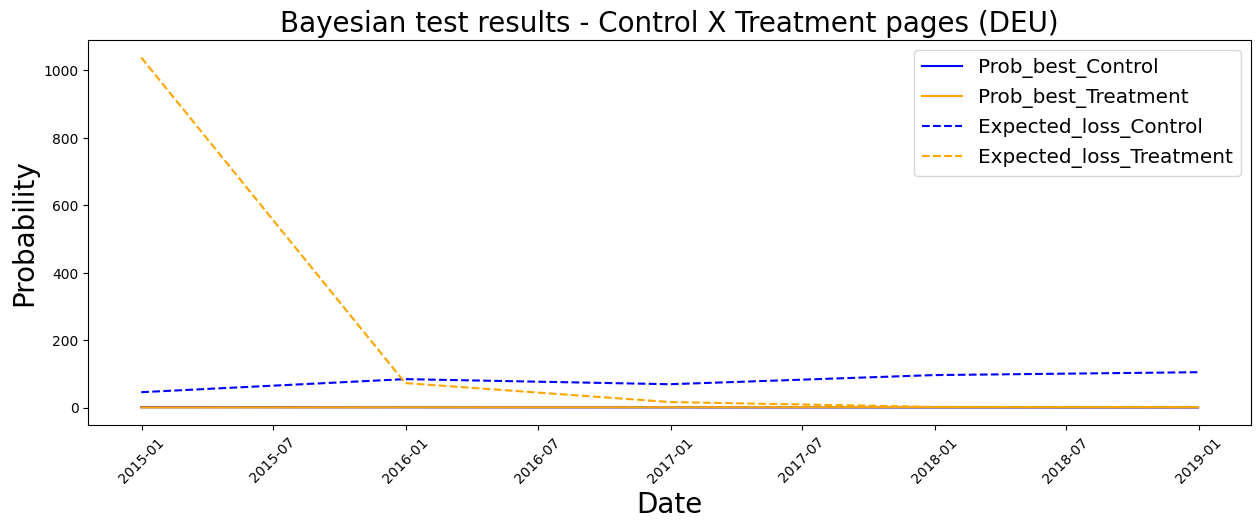

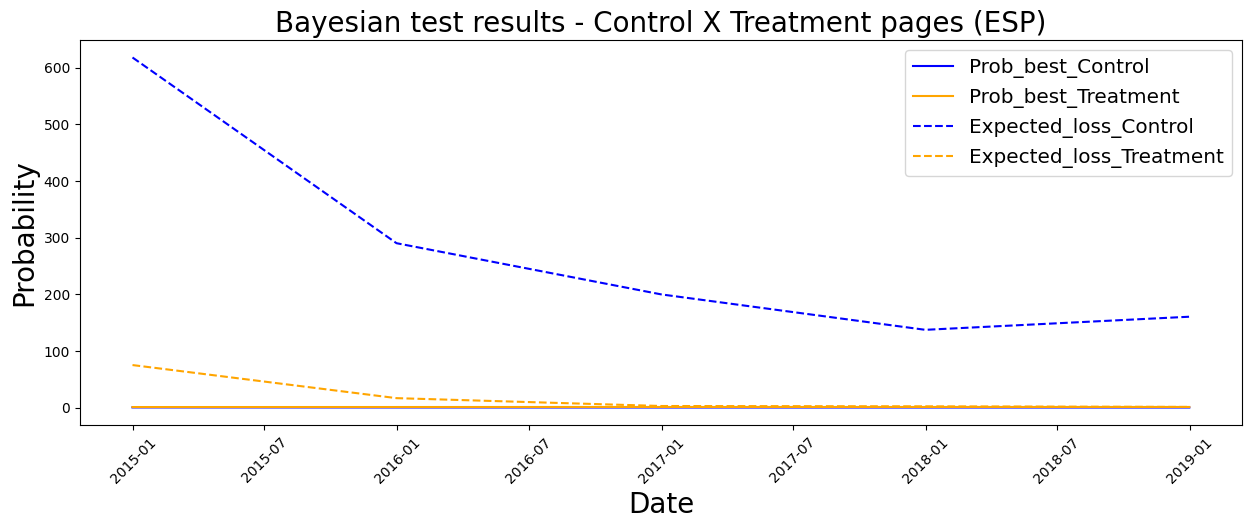

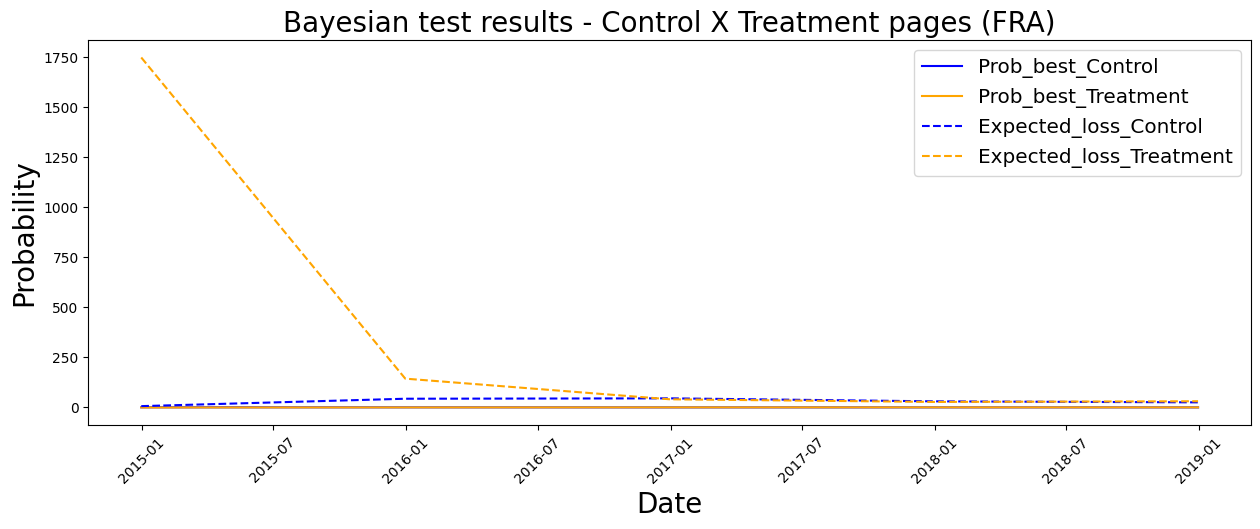

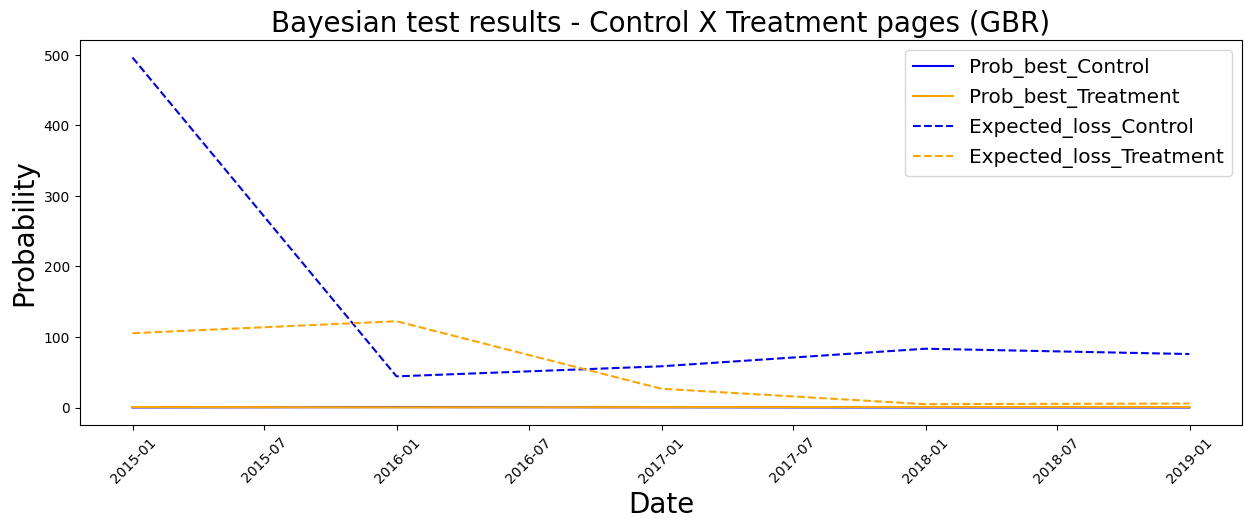

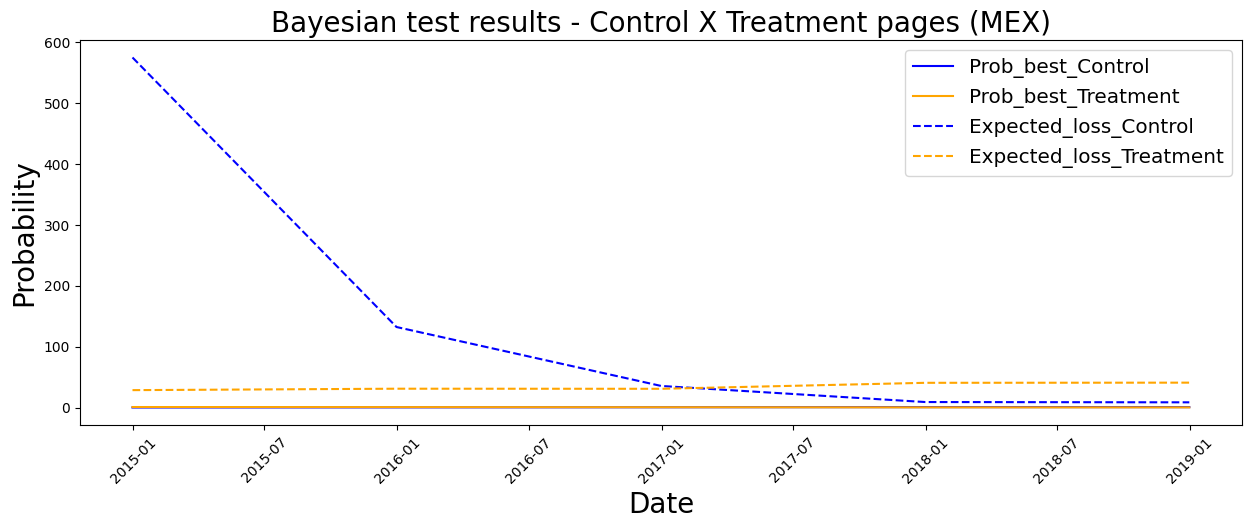

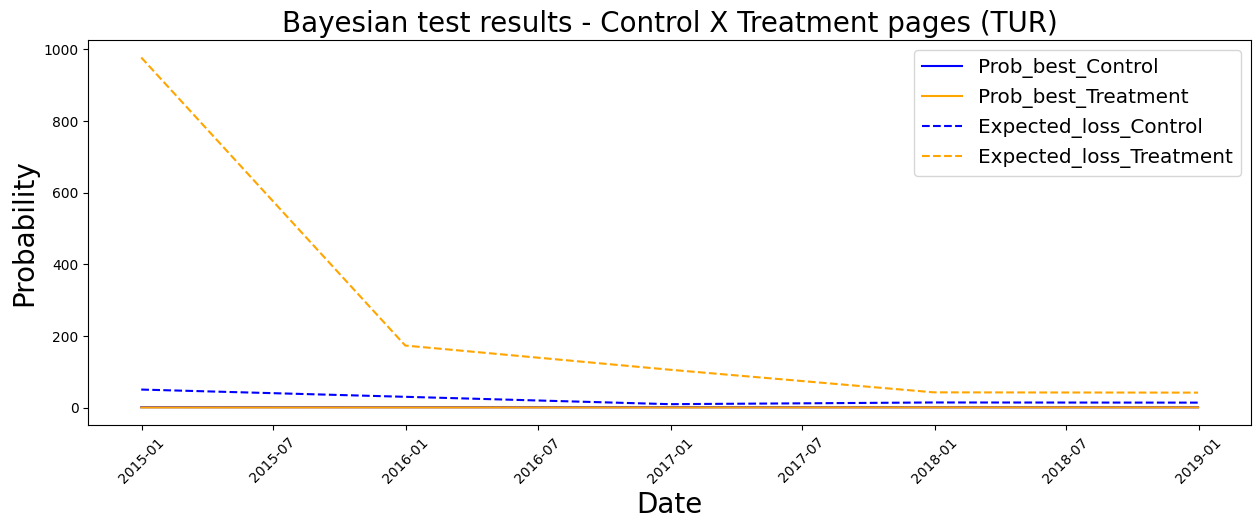

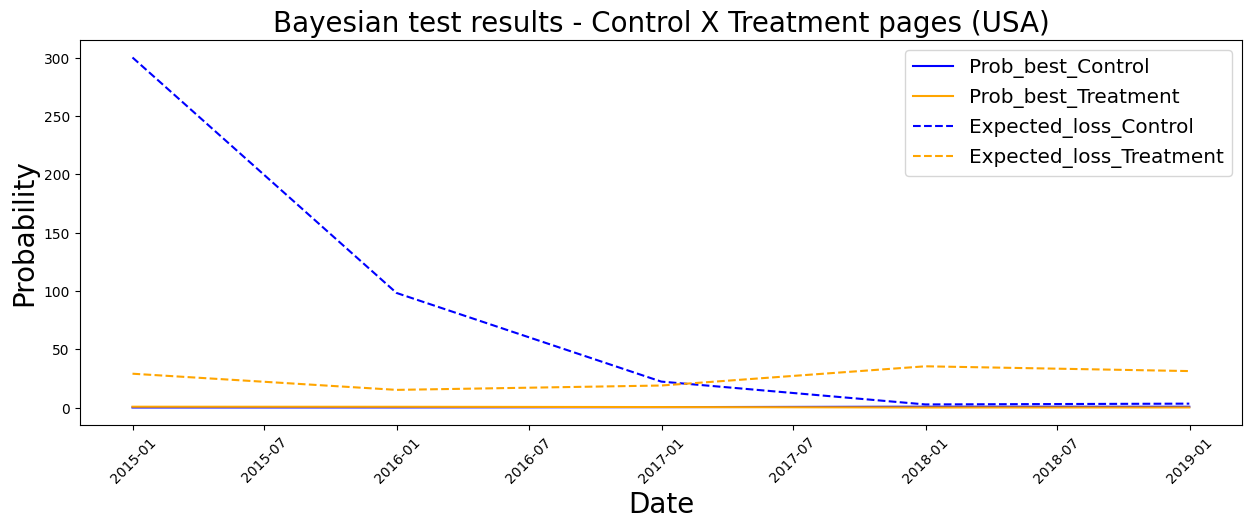

In [102]:

# Ploting results by country

for country in df_grouped['country'].unique():
    
    #
    country = country
    
    plt.figure(figsize=(15,5)) # seting figure size
    
    # Prob best:
    
    plt.plot(df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP A'), 'date'],
             df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP A'), 'prob_being_best'],
             label='Prob_best_Control', color='Blue')
    
    plt.plot(df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP B'), 'date'],
             df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP B'), 'prob_being_best'],
             label='Prob_best_Treatment', color='Orange')
    
    # Expected loss:
    
    plt.plot(df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP A'), 'date'],
             df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP A'), 'expected_loss'],
             label='Expected_loss_Control', color='Blue', linestyle='--')
    
    plt.plot(df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP B'), 'date'],
             df_grouped.loc[(df_grouped['country']==country) & (df_grouped['group']=='GRP B'), 'expected_loss'],
             label='Expected_loss_Treatment', color='Orange', linestyle='--')
    
    
    plt.legend(loc='best', fontsize='x-large') # add legend box
    
    
    plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
    plt.ylabel('Probability', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.title(f'Bayesian test results - Control X Treatment pages ({country})', fontdict = {'color':'black','size':20}) # add title to the plot
    
    plt.xticks(rotation=45); # rotate xticks

### 2.7 - Frequentist X Bayesian approach

In [36]:
df_frequentist = df_grouped[['date','country','group','spent']].copy()

In [37]:
df_frequentist

,date,country,group,spent
0,2014-12-31,AUS,GRP A,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ..."
1,2014-12-31,AUS,GRP B,"[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]"
2,2014-12-31,BRA,GRP A,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ..."
3,2014-12-31,BRA,GRP B,"[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249..."
4,2014-12-31,CAN,GRP A,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]"
...,...,...,...,...
95,2018-12-31,MEX,GRP B,"[1398, 2494, 997, 5684, 3194, 2395, 2495, 3095..."
96,2018-12-31,TUR,GRP A,"[3490, 7480, 2394, 3890, 599, 1098, 599, 1996,..."
97,2018-12-31,TUR,GRP B,"[198, 299, 3190, 6086, 499, 2194, 2096, 1795, ..."
98,2018-12-31,USA,GRP A,"[697, 2492, 898, 299, 1696, 2595, 798, 1597, 8..."


In [38]:
df_frequentist = df_frequentist.pivot(columns='group', values='spent', index=['date','country']).reset_index()

df_frequentist.head()

group,date,country,GRP A,GRP B
0,2014-12-31,AUS,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...","[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]"
1,2014-12-31,BRA,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...","[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249..."
2,2014-12-31,CAN,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]","[1795, 2894, 499, 1097, 696]"
3,2014-12-31,DEU,"[4292, 599, 2297, 1994, 5587, 2494, 798, 1395,...","[3095, 1197, 798, 797, 1995, 1198, 698, 6884, ..."
4,2014-12-31,ESP,"[1595, 2795, 898, 2293, 1597, 1197, 3392, 1098...","[1594, 499, 1796, 3591, 1595, 3989, 798, 599, ..."


In [39]:
# Removing the index name 'group'

df_frequentist = df_frequentist.rename_axis(None, axis=1)

df_frequentist.head()

,date,country,GRP A,GRP B
0,2014-12-31,AUS,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...","[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]"
1,2014-12-31,BRA,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...","[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249..."
2,2014-12-31,CAN,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]","[1795, 2894, 499, 1097, 696]"
3,2014-12-31,DEU,"[4292, 599, 2297, 1994, 5587, 2494, 798, 1395,...","[3095, 1197, 798, 797, 1995, 1198, 698, 6884, ..."
4,2014-12-31,ESP,"[1595, 2795, 898, 2293, 1597, 1197, 3392, 1098...","[1594, 499, 1796, 3591, 1595, 3989, 798, 599, ..."


In [40]:
# Creating sampled columns of GRP A and GRP B to equal the n of both

random.seed(42)
df_frequentist['sampled GRP A'] = df_frequentist[['GRP A', 'GRP B']].apply(lambda x: random.sample(x['GRP A'], min([len(x['GRP A']), len(x['GRP B'])])), axis=1)

random.seed(42)
df_frequentist['sampled GRP B'] = df_frequentist[['GRP A', 'GRP B']].apply(lambda x: random.sample(x['GRP B'], min([len(x['GRP A']), len(x['GRP B'])])), axis=1)

In [42]:
df_frequentist

,date,country,GRP A,GRP B,sampled GRP A,sampled GRP B
0,2014-12-31,AUS,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...","[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]","[798, 499, 1694, 1796, 2297, 4189, 1397, 3891,...","[199, 997, 2296, 1497, 997, 798, 597, 1795, 698]"
1,2014-12-31,BRA,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...","[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249...","[3094, 598, 398, 1797, 299, 2993, 499, 798, 99...","[1098, 3295, 2593, 1195, 4890, 2894, 897, 598,..."
2,2014-12-31,CAN,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]","[1795, 2894, 499, 1097, 696]","[2195, 599, 199, 1795, 1996]","[1795, 1097, 2894, 499, 696]"
3,2014-12-31,DEU,"[4292, 599, 2297, 1994, 5587, 2494, 798, 1395,...","[3095, 1197, 798, 797, 1995, 1198, 698, 6884, ...","[1994, 599, 798, 5587, 1395, 2494, 1696, 2297,...","[1198, 1198, 2194, 797, 1296, 1995, 698, 997, ..."
4,2014-12-31,ESP,"[1595, 2795, 898, 2293, 1597, 1197, 3392, 1098...","[1594, 499, 1796, 3591, 1595, 3989, 798, 599, ...","[2392, 1596, 898, 1498, 2293, 398, 1098, 3392,...","[1397, 3091, 1394, 7382, 2992, 3093, 3591, 398..."
5,2014-12-31,FRA,"[1894, 1196, 3592, 3193, 1597, 3191, 3992, 269...","[1296, 2593, 1196, 898, 1997, 1496, 998, 299, ...","[3193, 1894, 3191, 3992, 1597, 1196, 2693, 199...","[2593, 898, 798, 1496, 1697, 1795, 299, 998, 1..."
6,2014-12-31,GBR,"[1097, 2295, 997, 1795, 898, 299, 2695, 1695, ...","[3191, 2295, 1795, 3093, 1497, 1896, 698, 1198...","[1594, 797, 997, 898, 1697, 1795, 3294, 499, 1...","[1198, 1497, 1097, 499, 798, 3092, 698, 1896, ..."
7,2014-12-31,MEX,"[2494, 1596, 898, 1098, 1596, 299, 3194, 899, ...","[1398, 2494, 997, 5684, 3194, 2395, 2495, 3095...","[1098, 1894, 2294, 1596, 1098, 299, 7083, 2194...","[898, 99, 3194, 1995, 2095, 698, 5091, 1398, 8..."
8,2014-12-31,TUR,"[3490, 7480, 2394, 3890, 599, 1098, 599, 1996,...","[198, 299, 3190, 6086, 499, 2194, 2096, 1795, ...","[2892, 3890, 2395, 2196, 599, 599, 1098, 1697,...","[3091, 2096, 499, 499, 2194, 2494, 697, 1197, ..."
9,2014-12-31,USA,"[697, 2492, 898, 299, 1696, 2595, 798, 1597, 8...","[1994, 897, 3194, 1895, 2695, 899, 1896, 199, ...","[1796, 598, 1797, 2495, 1694, 898, 4689, 1497,...","[3295, 1697, 797, 2595, 199, 299, 1595, 5688, ..."


In [53]:
# Creating 'mean GRP A' column

df_frequentist['mean GRP A'] = df_frequentist['sampled GRP A'].apply(lambda x: round(np.mean(x), 2))

# Creating 'mean GRP B' column

df_frequentist['mean GRP B'] = df_frequentist['sampled GRP B'].apply(lambda x: round(np.mean(x), 2))

In [55]:
# Applying normality test (Shapiro if n<500 or Kolmogorov-Smirnov (K-S) if n>5000)

df_frequentist['Normality test p-value'] = df_frequentist[['sampled GRP A', 'sampled GRP B']].apply(lambda x: stats.shapiro(x['sampled GRP A']+x['sampled GRP B']).pvalue if len(x['sampled GRP A']+x['sampled GRP B'])<5000 else stats.kstest(x['sampled GRP A']+x['sampled GRP B'], stats.norm.cdf)[1], axis=1)

# SE O p<0.05 O DADO NÃO SEGUE UMA DISTRIBUIÇÃO NORMAL

In [56]:
# Variance ratio calculation -> variância maior entre GRP A e B / variância menor entre GRP A e B

df_frequentist['Variance ratio'] = df_frequentist[['sampled GRP A','sampled GRP B','Normality test p-value']].apply(lambda x: max([np.var(x['sampled GRP A']),np.var(x['sampled GRP B'])])/min([np.var(x['sampled GRP A']),np.var(x['sampled GRP B'])]) , axis=1)

In [57]:
# Applying the appropriate hypothesis tests (dependent on distribution and variance)

df_frequentist['Hypothesis test p-value'] = df_frequentist[['sampled GRP A',
                                                            'sampled GRP B',
                                                            'Normality test p-value',
                                                            'Variance ratio']].apply(lambda x: 
                                                                                     
                                                                                             # Condição para teste não paramétrico de variâncias iguais (Mann-Whitney)
                                                                                             stats.mannwhitneyu(x=x['sampled GRP A'],
                                                                                                                y=x['sampled GRP B'],
                                                                                                                use_continuity=True,
                                                                                                                alternative='two-sided',
                                                                                                                axis=0,
                                                                                                                method='auto',
                                                                                                                nan_policy='propagate',
                                                                                                                keepdims=False).pvalue if x['Normality test p-value']<0.05 and x['Variance ratio']<4
                                                                                             
                                                                                             # Condição para teste não paramétrico de variâncias diferentes (teste Welch)
                                                                                             else welch_ttest(x['sampled GRP A'],
                                                                                                              x['sampled GRP B']) if x['Normality test p-value']<0.05 and x['Variance ratio']>4
                                                                                             
                                                                                             # Condição para teste paramétrico de variâncias iguais (Parametric ttest equal variances)
                                                                                             else stats.ttest_ind(a=x['sampled GRP A'],
                                                                                                                  b=x['sampled GRP B'],
                                                                                                                  equal_var= True).pvalue if x['Normality test p-value']>0.05 and x['Variance ratio']<4
                                                                                             
                                                                                             # Condição para teste paramétrico de variâncias diferentes (Parametric ttest unequal variances)
                                                                                             else stats.ttest_ind(a=x['sampled GRP A'],
                                                                                                                  b=x['sampled GRP B'],
                                                                                                                  equal_var=False).pvalue
                                                                                             
                                                                                             , axis=1)

In [58]:
df_frequentist

,date,country,GRP A,GRP B,sampled GRP A,sampled GRP B,mean GRP A,mean GRP B,Normality test p-value,Variance ratio,Hypothesis test p-value
0,2014-12-31,AUS,"[499, 798, 3891, 1996, 1694, 4189, 2297, 499, ...","[997, 199, 1497, 698, 798, 2296, 1795, 597, 997]","[798, 499, 1694, 1796, 2297, 4189, 1397, 3891,...","[199, 997, 2296, 1497, 997, 798, 597, 1795, 698]",2061.89,1097.11,2.880044e-02,3.700505,0.084767
1,2014-12-31,BRA,"[3191, 1797, 398, 1596, 2195, 299, 1697, 398, ...","[2995, 1195, 2593, 2094, 1595, 4890, 3093, 249...","[3094, 598, 398, 1797, 299, 2993, 499, 798, 99...","[1098, 3295, 2593, 1195, 4890, 2894, 897, 598,...",1747.83,2150.81,9.583559e-05,1.116737,0.112605
2,2014-12-31,CAN,"[2195, 199, 1795, 1397, 499, 599, 2994, 1996]","[1795, 2894, 499, 1097, 696]","[2195, 599, 199, 1795, 1996]","[1795, 1097, 2894, 499, 696]",1356.80,1396.20,5.502724e-01,1.176908,0.948555
3,2014-12-31,DEU,"[4292, 599, 2297, 1994, 5587, 2494, 798, 1395,...","[3095, 1197, 798, 797, 1995, 1198, 698, 6884, ...","[1994, 599, 798, 5587, 1395, 2494, 1696, 2297,...","[1198, 1198, 2194, 797, 1296, 1995, 698, 997, ...",2609.15,1611.46,3.061566e-04,1.018895,0.090422
4,2014-12-31,ESP,"[1595, 2795, 898, 2293, 1597, 1197, 3392, 1098...","[1594, 499, 1796, 3591, 1595, 3989, 798, 599, ...","[2392, 1596, 898, 1498, 2293, 398, 1098, 3392,...","[1397, 3091, 1394, 7382, 2992, 3093, 3591, 398...",1635.93,2347.07,3.665325e-04,3.933967,0.319452
5,2014-12-31,FRA,"[1894, 1196, 3592, 3193, 1597, 3191, 3992, 269...","[1296, 2593, 1196, 898, 1997, 1496, 998, 299, ...","[3193, 1894, 3191, 3992, 1597, 1196, 2693, 199...","[2593, 898, 798, 1496, 1697, 1795, 299, 998, 1...",2643.75,1305.17,9.689941e-02,4.939973,0.009987
6,2014-12-31,GBR,"[1097, 2295, 997, 1795, 898, 299, 2695, 1695, ...","[3191, 2295, 1795, 3093, 1497, 1896, 698, 1198...","[1594, 797, 997, 898, 1697, 1795, 3294, 499, 1...","[1198, 1497, 1097, 499, 798, 3092, 698, 1896, ...",1425.94,1860.24,3.441781e-02,1.083873,0.214672
7,2014-12-31,MEX,"[2494, 1596, 898, 1098, 1596, 299, 3194, 899, ...","[1398, 2494, 997, 5684, 3194, 2395, 2495, 3095...","[1098, 1894, 2294, 1596, 1098, 299, 7083, 2194...","[898, 99, 3194, 1995, 2095, 698, 5091, 1398, 8...",1695.88,2017.25,5.355716e-06,1.051994,0.253579
8,2014-12-31,TUR,"[3490, 7480, 2394, 3890, 599, 1098, 599, 1996,...","[198, 299, 3190, 6086, 499, 2194, 2096, 1795, ...","[2892, 3890, 2395, 2196, 599, 599, 1098, 1697,...","[3091, 2096, 499, 499, 2194, 2494, 697, 1197, ...",2224.95,1555.80,6.595909e-05,1.284131,0.078494
9,2014-12-31,USA,"[697, 2492, 898, 299, 1696, 2595, 798, 1597, 8...","[1994, 897, 3194, 1895, 2695, 899, 1896, 199, ...","[1796, 598, 1797, 2495, 1694, 898, 4689, 1497,...","[3295, 1697, 797, 2595, 199, 299, 1595, 5688, ...",1656.67,1928.39,1.103034e-08,1.000506,0.116713


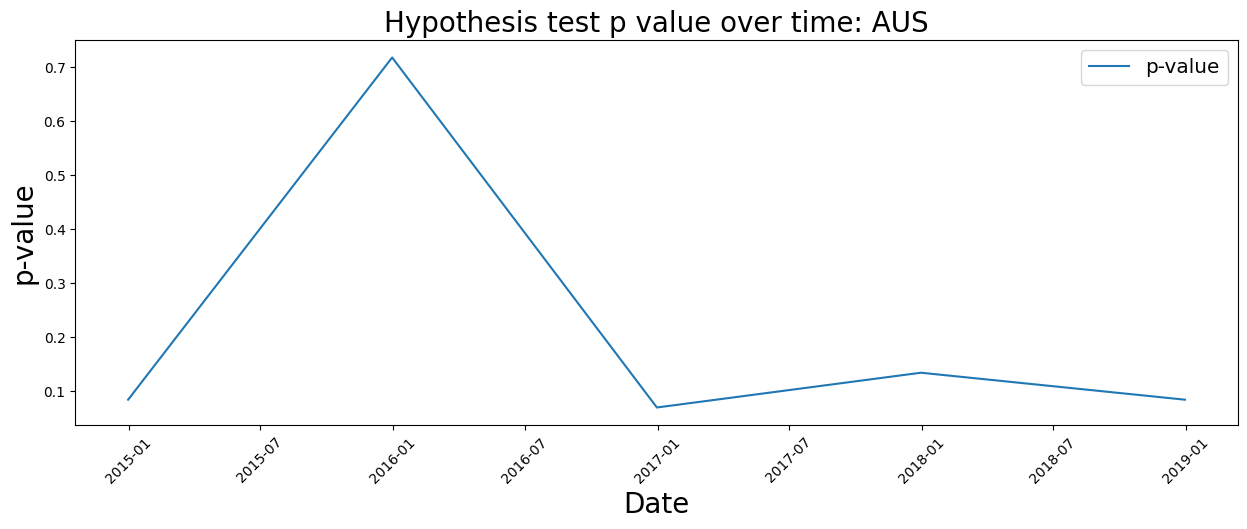

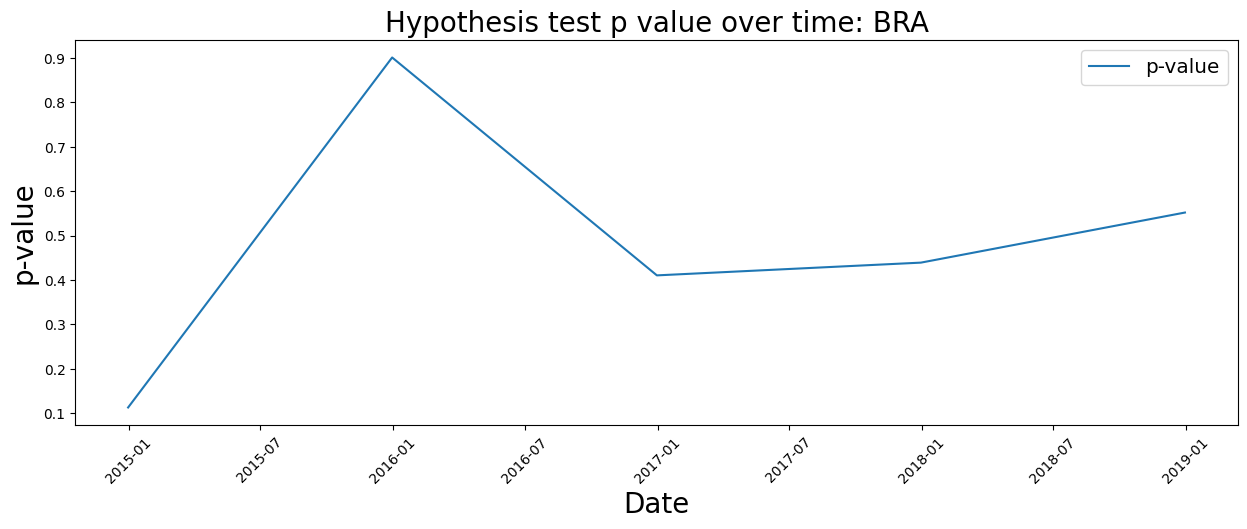

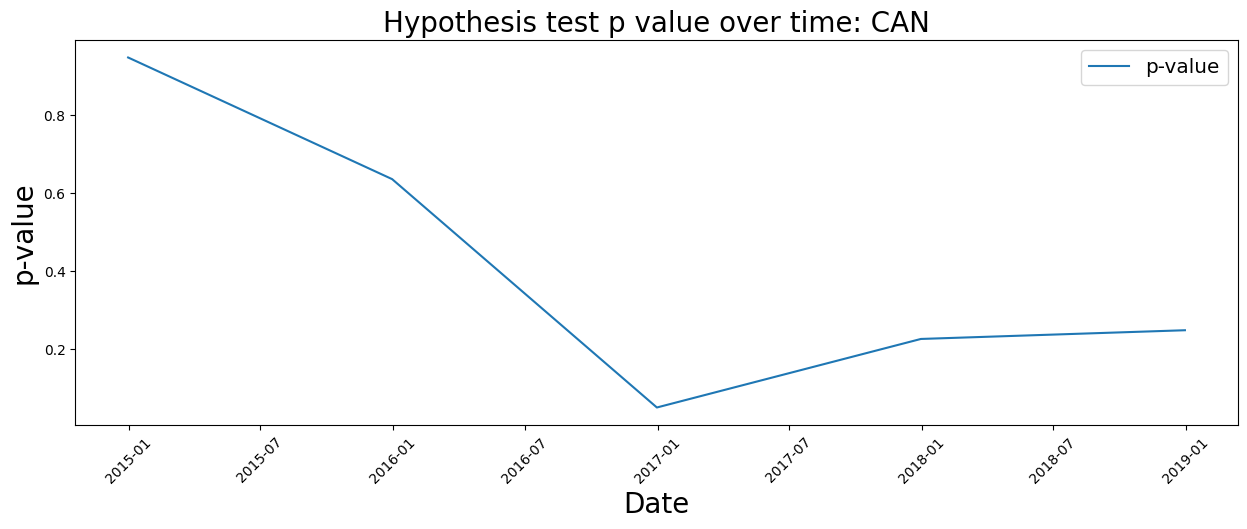

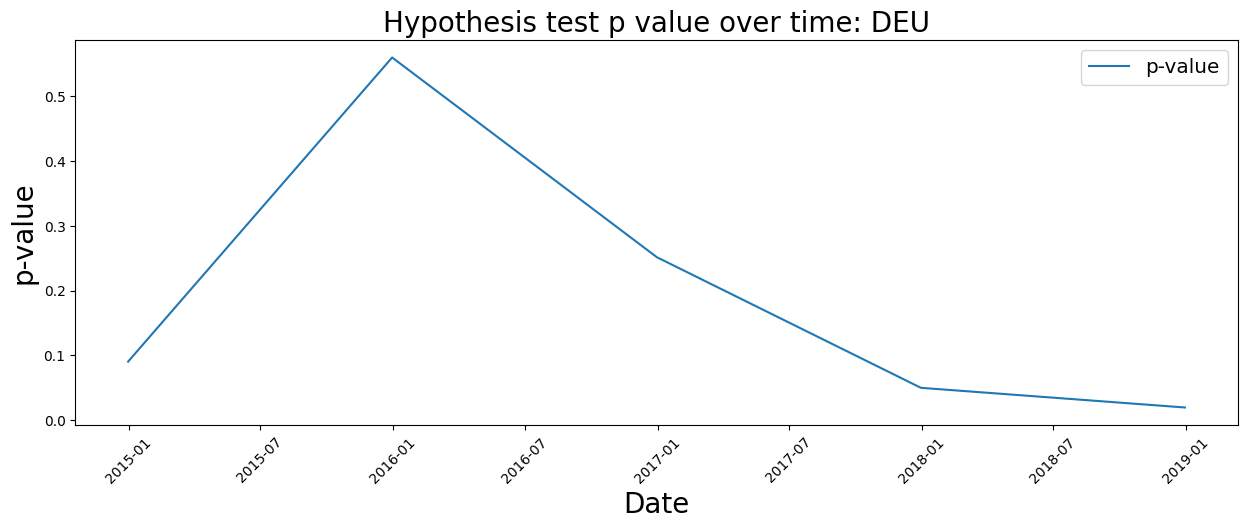

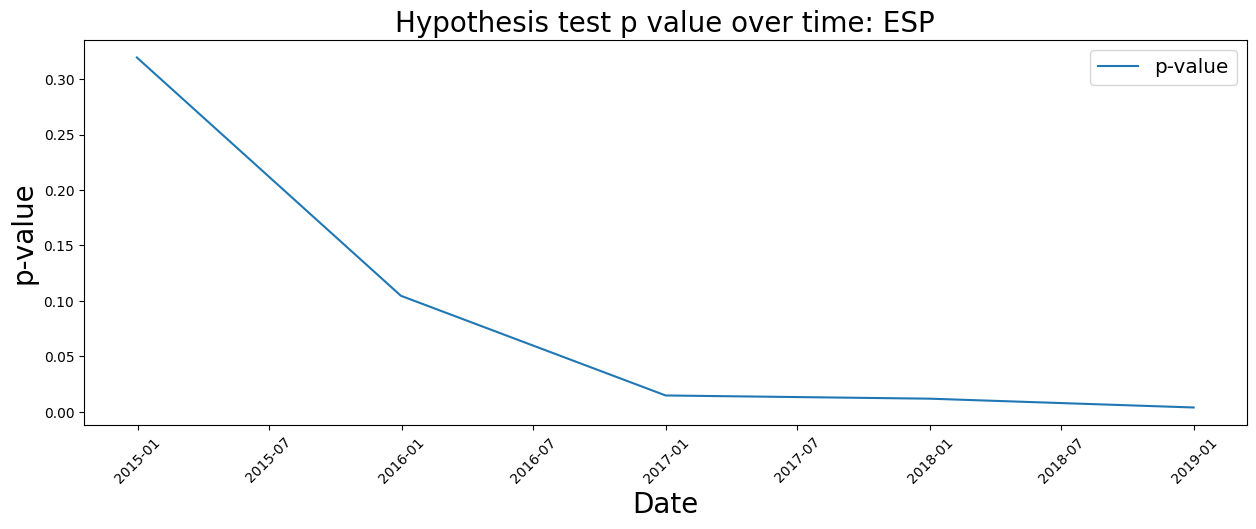

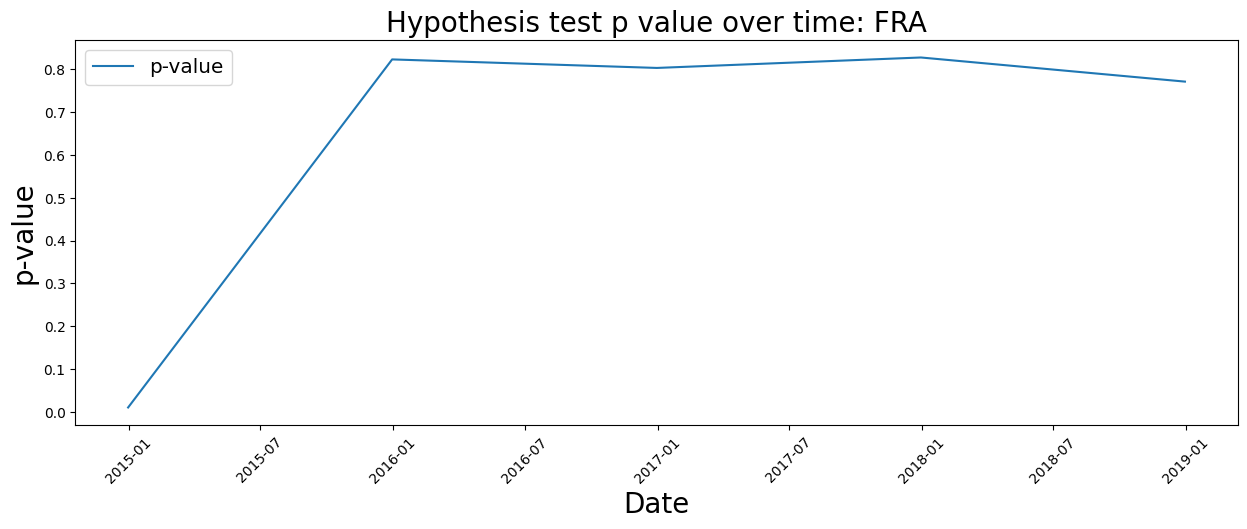

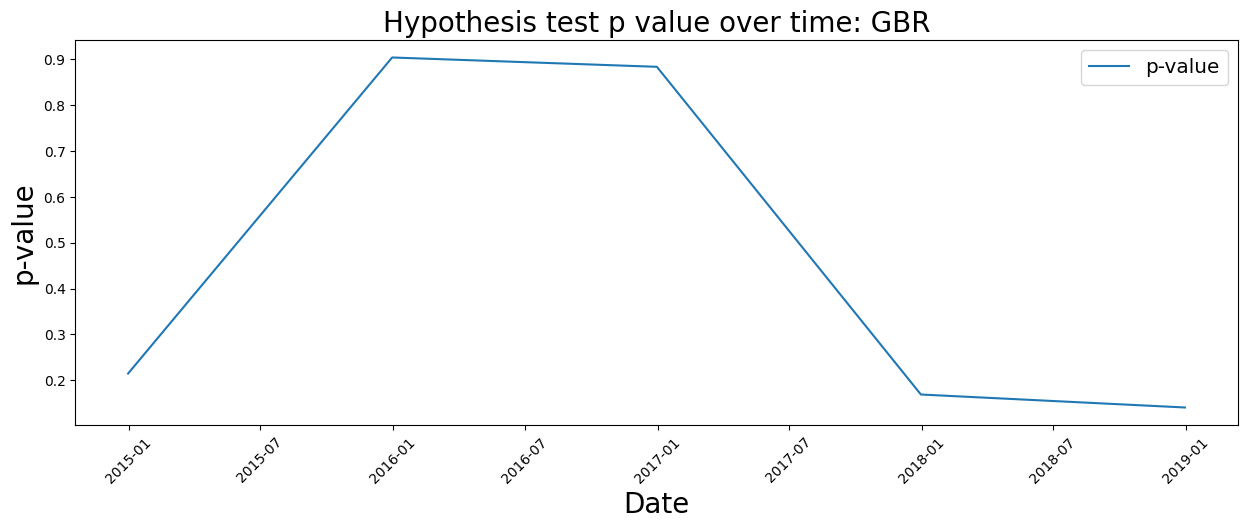

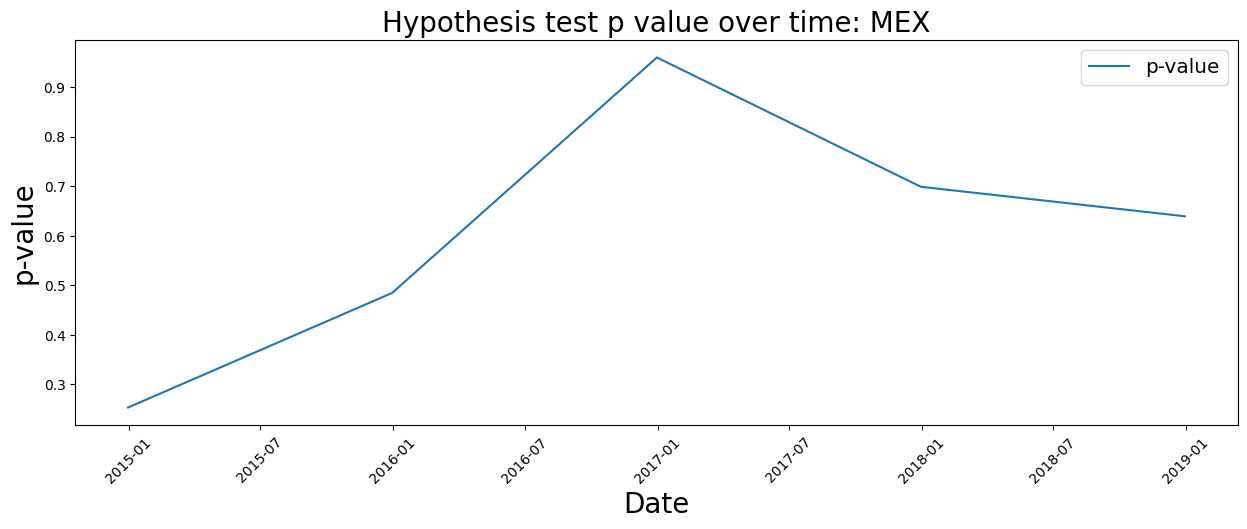

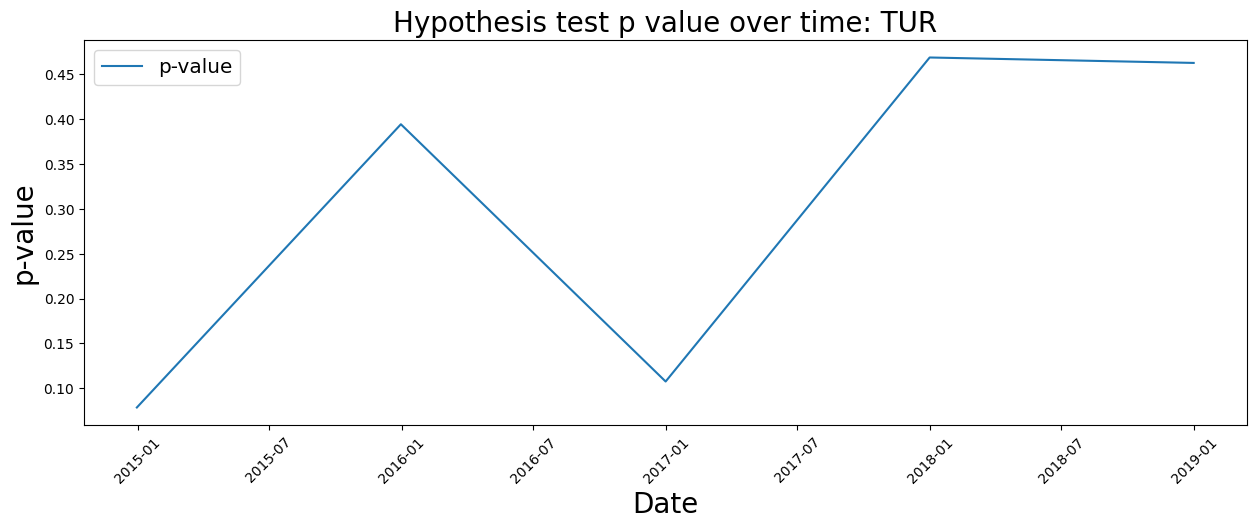

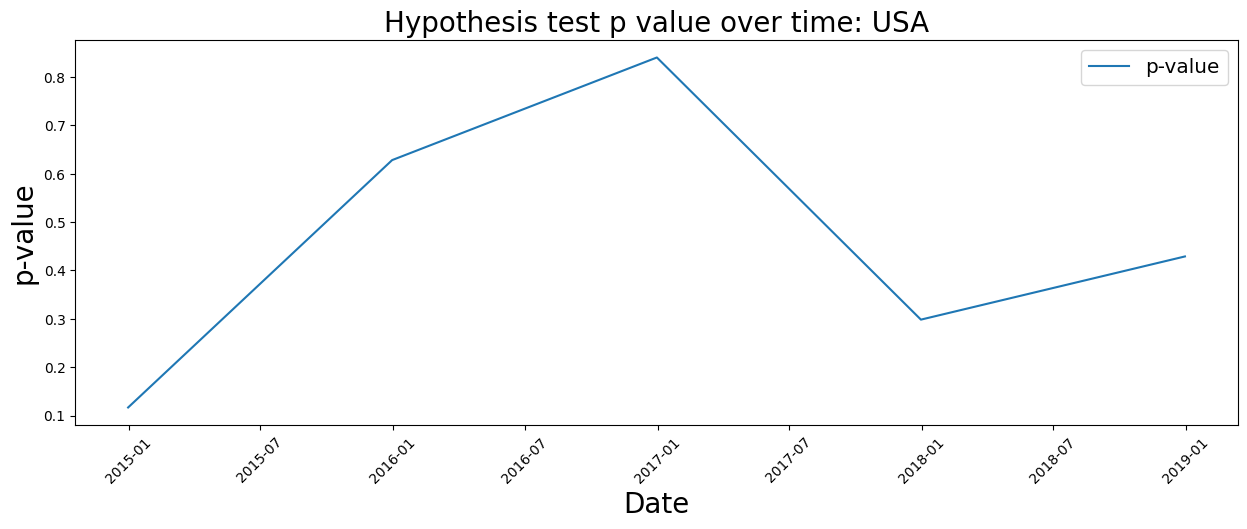

In [85]:
# Ploting results by country


for pais in df_frequentist['country'].unique():

    plt.figure(figsize=(15,5)) # seting figure size

    plt.plot(df_frequentist.loc[df_frequentist['country']==pais,'date'],
             df_frequentist.loc[df_frequentist['country']==pais,'Hypothesis test p-value'],
             label='p-value')
    
    plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.legend(loc='best', fontsize='x-large') # add legend box
    plt.ylabel('p-value', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.title(f'Hypothesis test p value over time: {pais}', fontdict = {'color':'black','size':20})
    
    plt.xticks(rotation=45); # rotate xticks

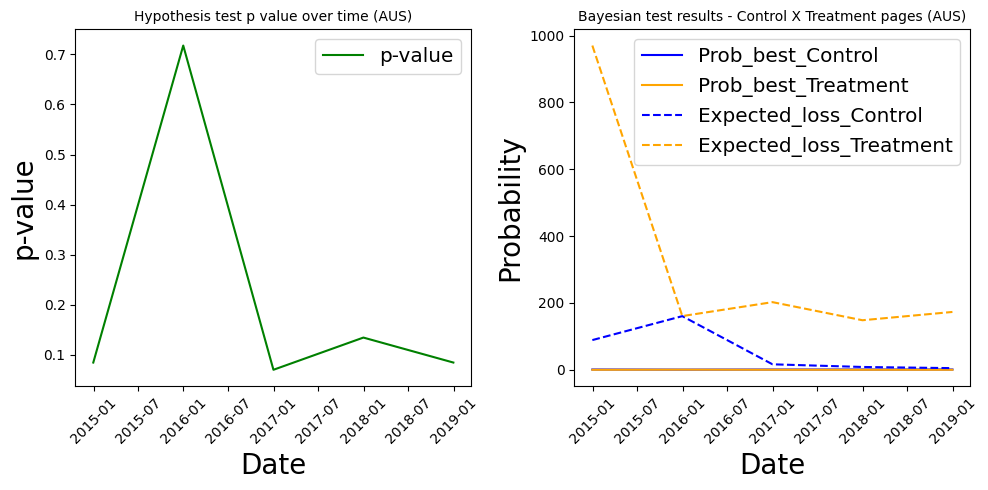

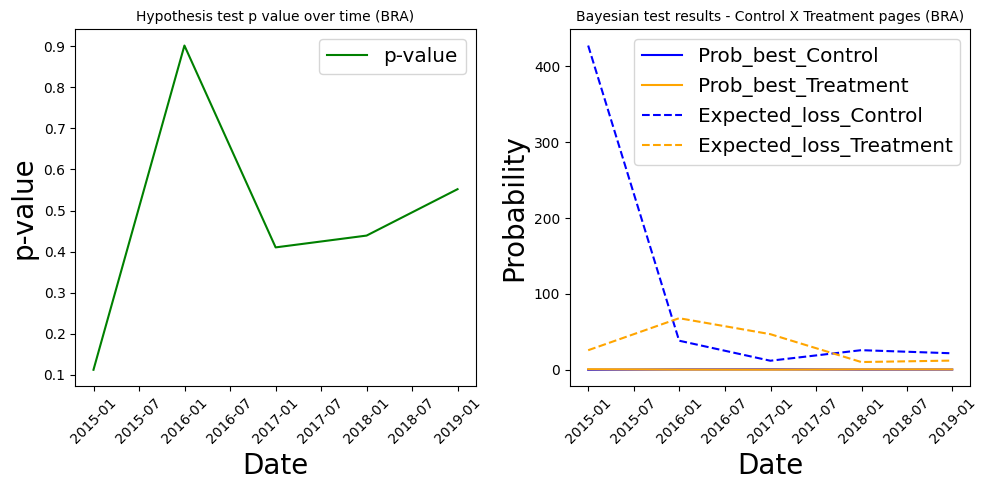

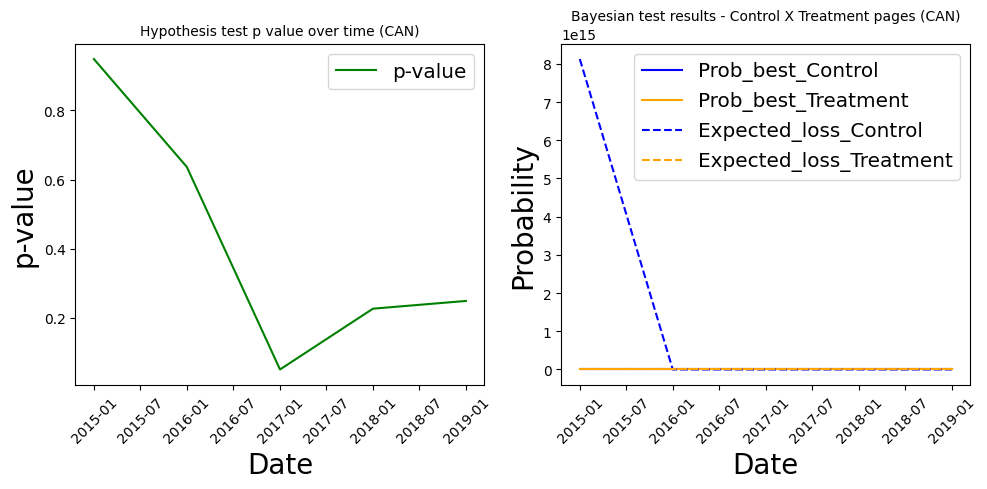

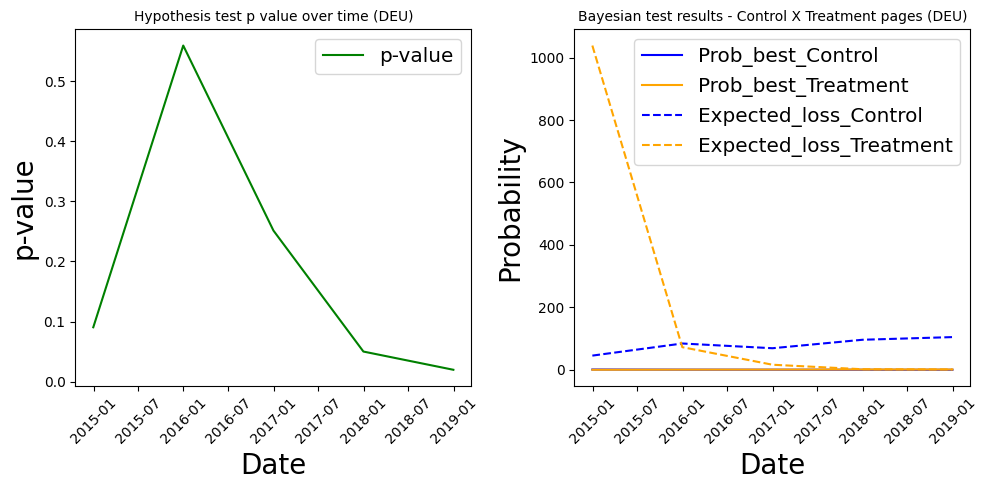

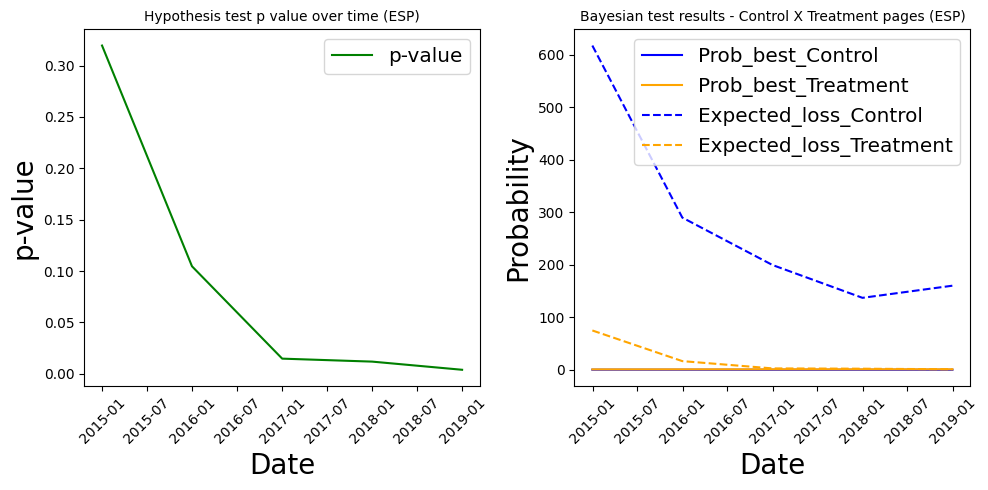

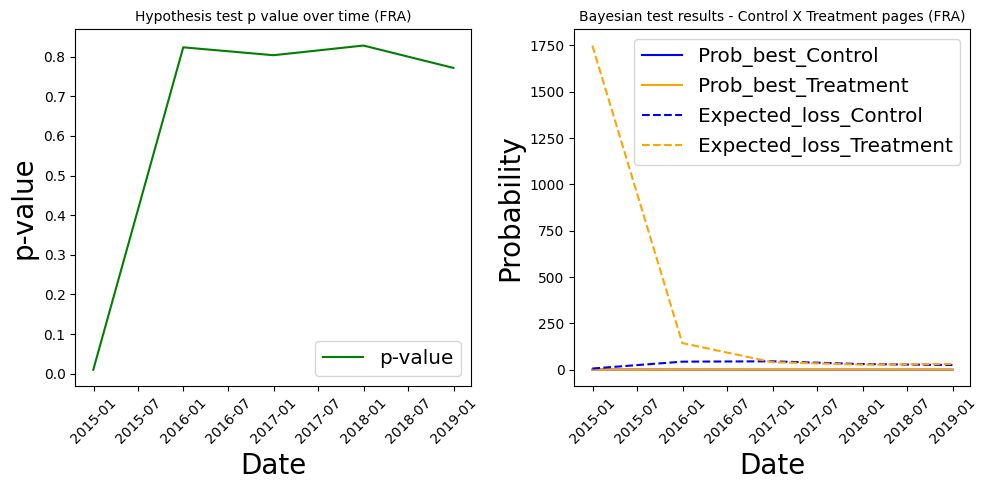

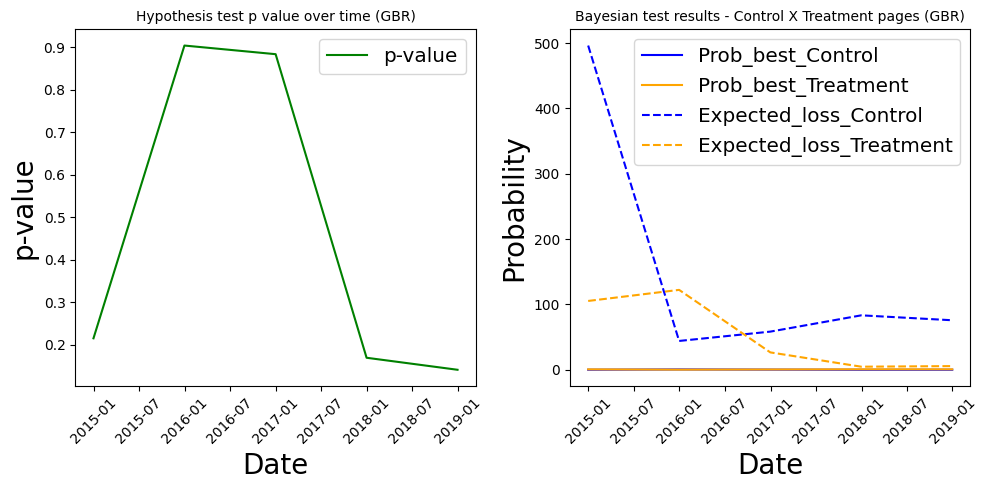

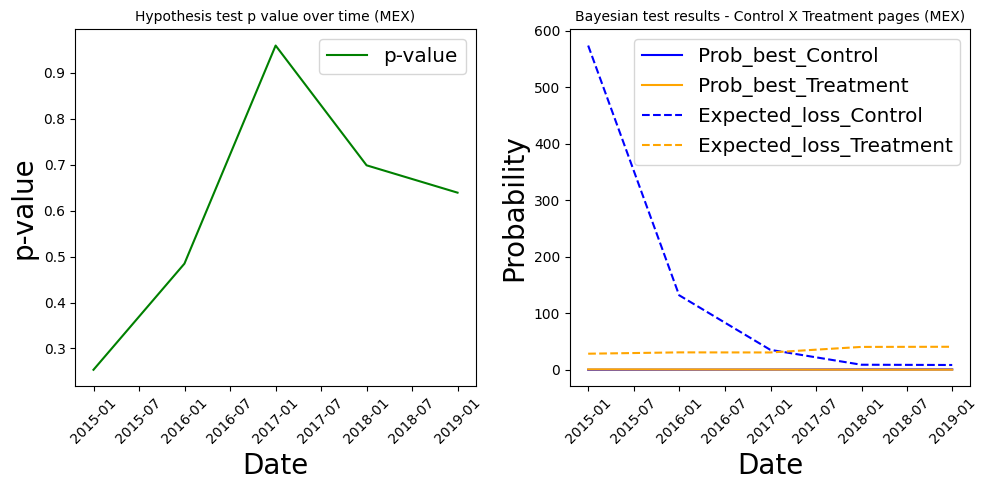

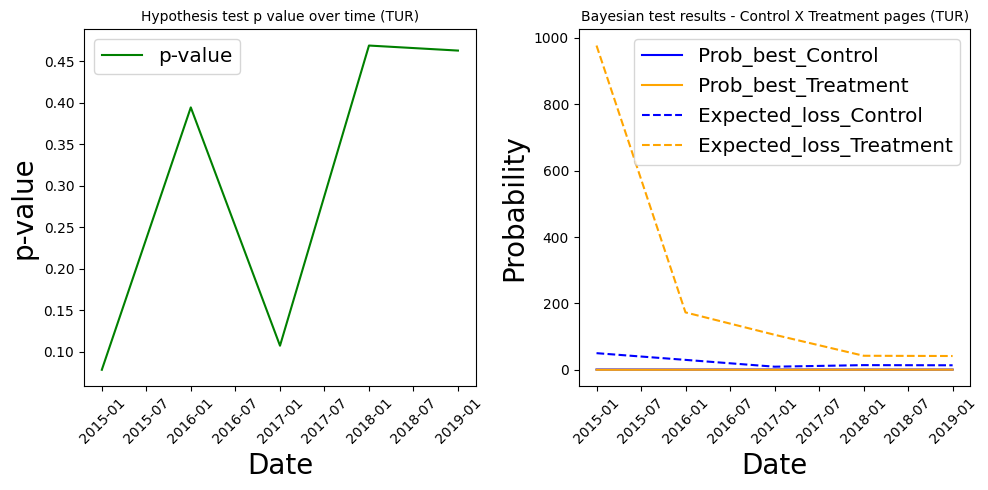

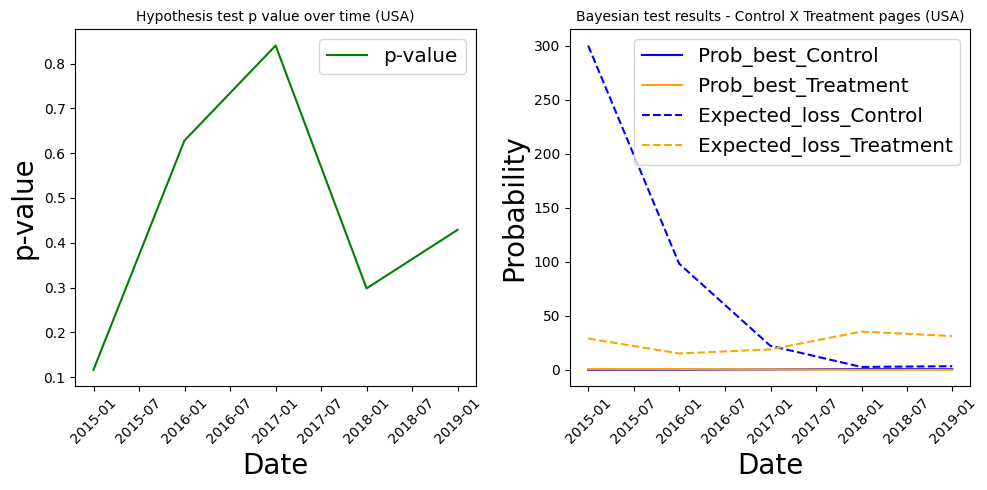

In [103]:
# Comparing frequentist X bayesian approach by country

for pais in df_frequentist['country'].unique():

    plt.figure(figsize=(10,5)) # seting figure size
    
    
    # ================= Frequentist test ===========================================
    
    plt.subplot(1,2,1)
    
    plt.plot(df_frequentist.loc[df_frequentist['country']==pais,'date'],
             df_frequentist.loc[df_frequentist['country']==pais,'Hypothesis test p-value'],
             label='p-value', color='green')
    
    plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.legend(loc='best', fontsize='x-large') # add legend box
    plt.ylabel('p-value', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.title(f'Hypothesis test p value over time ({pais})', fontdict = {'color':'black','size':10})
    
    plt.xticks(rotation=45) # rotate xticks
    
    
    # =============== Bayesian test ==============================================
    
    
    plt.subplot(1,2,2)
        
    # Prob best:
    
    plt.plot(df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP A'), 'date'],
             df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP A'), 'prob_being_best'],
             label='Prob_best_Control', color='Blue')
    
    plt.plot(df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP B'), 'date'],
             df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP B'), 'prob_being_best'],
             label='Prob_best_Treatment', color='Orange')
    
    # Expected loss:
    
    plt.plot(df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP A'), 'date'],
             df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP A'), 'expected_loss'],
             label='Expected_loss_Control', color='Blue', linestyle='--')
    
    plt.plot(df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP B'), 'date'],
             df_grouped.loc[(df_grouped['country']==pais) & (df_grouped['group']=='GRP B'), 'expected_loss'],
             label='Expected_loss_Treatment', color='Orange', linestyle='--')
    
    
    plt.legend(loc='best', fontsize='x-large') # add legend box
    
    
    plt.xlabel('Date', fontdict = {'color':'black','size':20}) # add xlabel legend
    plt.ylabel('Probability', fontdict = {'color':'black','size':20}) # add xlabel legend
    
    plt.title(f'Bayesian test results - Control X Treatment pages ({pais})', fontdict = {'color':'black','size':10}) # add title to the plot
    
    plt.xticks(rotation=45) # rotate xticks
    
    plt.tight_layout()

## <font color="blue">3 - References</font>

https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_ind_solve_power.html#statsmodels.stats.power.tt_ind_solve_power

https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

https://www.statology.org/determine-equal-or-unequal-variance/

https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_effectsize.html

https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a

https://pypi.org/project/bayesian-testing/

https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/

https://discourse.matplotlib.org/t/why-am-i-getting-this-matplotlib-error-for-plotting-a-categorical-variable/21758/2

## <font color="gray">Rascunhos</font>

In [106]:
# EXEMPLO ILUSTRATIVO -> DADOS NORMAIS CONVERGINDO PARA NÃO NORMAIS COM O AUMENTO DO N


df_frequentist.loc[df_frequentist['country']=='CAN', ['date', 'Normality test p-value']]

,date,Normality test p-value
2,2014-12-31,5.502724e-01
12,2015-12-31,2.048149e-07
22,2016-12-31,7.893814e-19
32,2017-12-31,9.013791e-28
42,2018-12-31,1.162695e-28


In [107]:
df_frequentist.loc[df_frequentist['country']=='DEU', ['date', 'Hypothesis test p-value']]

,date,Hypothesis test p-value
3,2014-12-31,0.090422
13,2015-12-31,0.559479
23,2016-12-31,0.251415
33,2017-12-31,0.049985
43,2018-12-31,0.019643


In [53]:
# Spent médio é de 1880

df[['group','spent']].groupby('group').mean().iloc[0,:]

# Dessa forma o objetivo da página B é aumentar o spent médio para 2000

spent    1880.504281
Name: GRP A, dtype: float64

In [58]:
# Spent médio atual 1880, faturamento:

1880 * 45883

86260040

In [61]:
# Spent médio desejado 2000, faturamento:

2000 * 45883

91766000

In [62]:
# Lift absoluto

(2000 * 45883) - (1880 * 45883)

5505960

In [24]:
# Taxa de conversão grupo controle 12%

df.loc[df['group']=='control', ['converted', 'non-converted']].mean()

converted        0.120386
non-converted    0.879614
dtype: float64

In [33]:
df.loc[df['group']=='treatment', ['converted', 'non-converted']].mean()

converted        0.118807
non-converted    0.881193
dtype: float64

In [118]:
# Grouping dataset by days of experiment and sum conversions and non-conversions

df_dailly = df[['timestamp','group','converted','non-converted']].groupby([pd.Grouper(key='timestamp', freq='D'),'group']).sum().reset_index()

df_dailly.head()

,timestamp,group,converted,non-converted
0,2017-01-02,control,359,2500
1,2017-01-02,treatment,342,2511
2,2017-01-03,control,750,5840
3,2017-01-03,treatment,753,5865
4,2017-01-04,control,802,5776


In [119]:
# Generating accumulated columns for conversions and non-conversions

# Control -> converted
df_dailly.loc[df_dailly['group']=='control', 'acc_converted'] = df_dailly.loc[df_dailly['group']=='control', 'converted'].cumsum()

# Treatment -> converted
df_dailly.loc[df_dailly['group']=='treatment', 'acc_converted'] = df_dailly.loc[df_dailly['group']=='treatment', 'converted'].cumsum()


# Control -> non-converted
df_dailly.loc[df_dailly['group']=='control', 'acc_non-converted'] = df_dailly.loc[df_dailly['group']=='control', 'non-converted'].cumsum()

# Treatment -> non-converted
df_dailly.loc[df_dailly['group']=='treatment', 'acc_non-converted'] = df_dailly.loc[df_dailly['group']=='treatment', 'non-converted'].cumsum()

In [235]:
df_teste = pd.DataFrame({'Date':[pd.to_datetime('2022-01-01'), pd.to_datetime('2022-01-01'), pd.to_datetime('2022-01-01'), pd.to_datetime('2022-01-01'), pd.to_datetime('2022-01-02'), pd.to_datetime('2022-01-02'), pd.to_datetime('2022-01-02'), pd.to_datetime('2022-01-02')],
                         'País': ['Brazil','Brazil', 'Mexico', 'Mexico', 'Brazil','Brazil', 'Mexico', 'Mexico'],
                         'Spent': [200, 300, 100, 400,  300, 100, 300, 100]},
                        )

df_teste

,Date,País,Spent
0,2022-01-01,Brazil,200
1,2022-01-01,Brazil,300
2,2022-01-01,Mexico,100
3,2022-01-01,Mexico,400
4,2022-01-02,Brazil,300
5,2022-01-02,Brazil,100
6,2022-01-02,Mexico,300
7,2022-01-02,Mexico,100
